In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import asciitable
import pyfits
import os
import physical_scale_func as phys
import re
import csv
import math
from cosmocalc import cosmocalc

In [4]:
galfit = "/Users/rdavari/Documents/Paper3_Codes/galfit"
PATH = '/Users/rdavari/Documents/Paper3_Codes/'

singleSer = pd.read_csv(PATH + 'SM/1comp.csv')
singleSer = singleSer[singleSer.fitGoodness == 'high']
singleSer['re_kpc'] = singleSer['re_kpc']*np.sqrt(1-singleSer['e'])

twoComp = pd.read_csv(PATH + 'SM/2comp.csv')
twoComp = twoComp[twoComp.fitGoodness == 'high']
twoComp['Re_b_kpc'] = twoComp['Re_b_kpc']*np.sqrt(1-twoComp['e_b'])
twoComp['h_kpc'] = twoComp['h_kpc']*np.sqrt(1-twoComp['e_d'])

In [27]:
singleSer.Mag_1d.describe()

count    246.000000
mean      20.975565
std        1.161443
min       17.306000
25%       20.077500
50%       21.167500
75%       21.751000
max       23.723000
Name: Mag_1d, dtype: float64

In [30]:
singleSer['Mag_1d_cor'] = [row['Mag_1d'] - 5*np.log10(cosmocalc(float(row['z']))['DL_Gyr']/cosmocalc(.1)['DL_Gyr']) 
                        for index,row in singleSer.iterrows()]

singleSer.Mag_1d_cor.describe()

count    246.000000
mean      13.917953
std        0.632583
min       11.795000
25%       13.677382
50%       13.973548
75%       14.230363
max       15.602850
Name: Mag_1d_cor, dtype: float64

# Helper Function 

In [5]:
def medians_and_err(dataSet,para):

    z05,z10,z15,z20 = four_bin(dataSet)
    
    z05_all = np.median(z05[para])
    z10_all = np.median(z10[para])
    z15_all = np.median(z15[para])
    z20_all = np.median(z20[para])
    z05_all_low, z05_all_up = np.percentile(z05[para],[25,75])
    z10_all_low, z10_all_up = np.percentile(z10[para],[25,75])
    z15_all_low, z15_all_up = np.percentile(z15[para],[25,75])
    z20_all_low, z20_all_up = np.percentile(z20[para],[25,75])
    all = [z05_all,z10_all,z15_all,z20_all]
    all_low = [z05_all-z05_all_low,z10_all-z10_all_low,z15_all-z15_all_low,z20_all-z20_all_low]
    all_up = [z05_all_up-z05_all,z10_all_up-z10_all,z15_all_up-z15_all,z20_all_up-z20_all]

    z05_SF = np.median(z05[z05.SF1_Quies0 == 1][para])
    z10_SF = np.median(z10[z10.SF1_Quies0 == 1][para])
    z15_SF = np.median(z15[z15.SF1_Quies0 == 1][para])
    z20_SF = np.median(z20[z20.SF1_Quies0 == 1][para])
    z05_SF_low, z05_SF_up = np.percentile(z05[z05.SF1_Quies0 == 1][para],[25,75])
    z10_SF_low, z10_SF_up = np.percentile(z10[z10.SF1_Quies0 == 1][para],[25,75])
    z15_SF_low, z15_SF_up = np.percentile(z15[z15.SF1_Quies0 == 1][para],[25,75])
    z20_SF_low, z20_SF_up = np.percentile(z20[z20.SF1_Quies0 == 1][para],[25,75])
    SF = [z05_SF,z10_SF,z15_SF,z20_SF]
    SF_low = [z05_SF-z05_SF_low,z10_SF-z10_SF_low,z15_SF-z15_SF_low,z20_SF-z20_SF_low]
    SF_up = [z05_SF_up-z05_SF,z10_SF_up-z10_SF,z15_SF_up-z15_SF,z20_SF_up-z20_SF]

    z05_Que = np.median(z05[z05.SF1_Quies0 == 0][para])
    z10_Que = np.median(z10[z10.SF1_Quies0 == 0][para])
    z15_Que = np.median(z15[z15.SF1_Quies0 == 0][para])
    z20_Que = np.median(z20[z20.SF1_Quies0 == 0][para])
    z05_Que_low, z05_Que_up = np.percentile(z05[z05.SF1_Quies0 == 0][para],[25,75])
    z10_Que_low, z10_Que_up = np.percentile(z10[z10.SF1_Quies0 == 0][para],[25,75])
    z15_Que_low, z15_Que_up = np.percentile(z15[z15.SF1_Quies0 == 0][para],[25,75])
    z20_Que_low, z20_Que_up = np.percentile(z20[z20.SF1_Quies0 == 0][para],[25,75])
    Que = [z05_Que,z10_Que,z15_Que,z20_Que]
    Que_low = [z05_Que-z05_Que_low,z10_Que-z10_Que_low,z15_Que-z15_Que_low,z20_Que-z20_Que_low]
    Que_up = [z05_Que_up-z05_Que,z10_Que_up-z10_Que,z15_Que_up-z15_Que,z20_Que_up-z20_Que]
    
    return (all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up)

In [6]:
def four_bin(dataSet,lim1=1.1,lim2=1.6,lim3=2):
    z05,z10,z15,z20 = pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

    for galaxy in dataSet['Name']:
        data = dataSet[dataSet['Name'] == galaxy]

        if float(data.z.values) <= lim1:
            z05=z05.append(data)
        elif float(data.z.values) <= lim2:
            z10=z10.append(data)
        elif float(data.z.values) <= lim3:
            z15=z15.append(data)
        else:
            z20=z20.append(data)

    #print len(z05), len(z10), len(z15), len(z20)
    #print dataSet.shape
    return (z05,z10,z15,z20)

In [17]:
def ks_test(dataSet,para):
    """
    KS two sample test for comparing the distribution of star-forming
    and quiescent galaxies
    """
    sf = np.array(dataSet[dataSet.SF1_Quies0 == 1][para])
    quie = np.array(dataSet[dataSet.SF1_Quies0 == 0][para])
    d, pvalue =  stats.ks_2samp(sf,quie)
    return (round(d,20),round(pvalue,20))

In [18]:
def anova(dataSet,para):
    """
    ANOVA test for testing whether or not the massive galaxies have evolved
    """
    z05,z10,z15,z20 = four_bin(dataSet)
    f, pvalue = stats.f_oneway(z05[para],z10[para], z15[para],z20[para])
    return (round(f,20),round(pvalue,20))

In [19]:
def bootstrap_median(group1,group2,nofSimulation=1000,nofSample=1000,plot_hist=False):
    """
    Purpose: Performs two groups independent tests and compares their median
    
    Note: This function is specifically designed for LA projects and the 
    independent test perfomed based on the funding status (funded or not)
    """
    
    median_diff = []

    # Bootstraping: finding the median differences and severl (nofSimulation) resample of
    # funded and not funded projects. 
    for i in xrange(nofSimulation):
        median1 = group1.iloc[np.random.randint(0, len(group1), size=len(group1))].median()
        median2 = group2.iloc[np.random.randint(0, len(group2), size=len(group2))].median()
        median_diff.append(median1 - median2)

    # The number of simulations and resample size will be more than
    # couple of thousands --> use normal z test (CLT)
    mean = np.mean(median_diff)
    SD = np.std(median_diff)
    z = mean/SD
    z = min(-z,z)  # Two sided test --> use the lower quantile
    pValue = 2*stats.norm.cdf(z)
    percLow, percHigh = np.percentile(median_diff,[2.5,97.5])


    print 'The mean of median difference of is {0}, the confidence interval=({1},{2}), and  p-value={3}.'.\
            format(round(mean,2),round(percLow,2),round(percHigh,2),round(pValue,2))


In [20]:
z05,z10,z15,z20 = four_bin(singleSer)
group1 = z05['e']
group2 = z20['e']
bootstrap_median(group1,group2)

The mean of median difference of is -0.07, the confidence interval=(-0.18,0.04), and  p-value=0.21.


In [21]:
d, pvalue =  stats.ks_2samp(group1,group2)
print pvalue

t, pvalue = scipy.stats.ttest_ind(group1,group2)
print pvalue

0.177383594678
0.100835979334


In [22]:
paras = [('R$_e$','re_kpc'),('n','n'),('e','e')]

stat_1comp = []
for para in paras:
    stat_1comp += [(para[0],) + anova(singleSer,para[1]) + ks_test(singleSer,para[1])]

stat_1comp
#asciitable.write(stat_1comp,'/Users/Roozbeh/Desktop/work/Writings/Paper3/1comp_stat.tex',Writer=asciitable.Latex) 

[('R$_e$',
  20.394724847585184,
  8.12274274e-12,
  0.283734011919909,
  8.108015574655933e-05),
 ('n',
  9.982596590271932,
  3.15333721549867e-06,
  0.3483559900890645,
  4.7910148592736e-07),
 ('e',
  1.656621096608608,
  0.1770216775498709,
  0.14625326458179877,
  0.1361182953104966)]

In [25]:
paras = [('$B/T$','BT'),('m$_{bulge}$','Mag_b_cor'),('m$_{disk}$','Mag_d_cor'),('R${_e_{bulge}}$','Re_b_kpc'),\
         ('n$_{bulge}$','n_b'),('e$_{bulge}$','e_b'),('h','h'),('e$_{disk}$','e_d')]

stat_2comp = []
for para in paras:
    stat_2comp += [(para[0],) + anova(twoComp,para[1]) + ks_test(twoComp,para[1])]

stat_2comp
#asciitable.write(stat_2comp,'/Users/Roozbeh/Desktop/work/Writings/Paper3/stat_2comp.tex',Writer=asciitable.Latex) 

[('$B/T$',
  13.361642511108096,
  4.358042007631e-08,
  0.49334733893557425,
  2.1558131e-13),
 ('m$_{bulge}$',
  12.926532531347945,
  7.524558759254e-08,
  0.48865546218487393,
  3.793902e-13),
 ('m$_{disk}$',
  6.931492137886458,
  0.00017186304354998617,
  0.2200280112044818,
  0.005268874083809848),
 ('R${_e_{bulge}}$',
  30.772939409358546,
  7.749e-17,
  0.20994397759103633,
  0.008968572759491221),
 ('n$_{bulge}$',
  17.921213057124707,
  1.6223227216e-10,
  0.24404761904761907,
  0.0013422470092287165),
 ('e$_{bulge}$',
  9.096149063552073,
  1.009375865798613e-05,
  0.34180672268907564,
  1.19251206777227e-06),
 ('h', 32.38468134382547, 1.402e-17, 0.11442577030812326, 0.39803977510456473),
 ('e$_{disk}$',
  0.09136480200161788,
  0.9647484099939635,
  0.10497198879551817,
  0.5085930575270858)]

# Size Evolution Slopes 

### Re 

In [20]:
all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(singleSer,'re_kpc')
z = [0.75,1.25,1.75,2.25]
x = np.log10(np.array(z)+1)

#################
##### BOTH ######
#################
y = np.log10(np.array(all))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print 'Both Class',slope, std_err

###############
##### SF ######
###############
y = np.log10(np.array(SF))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print 'Star-froming',slope, std_err

######################
##### Quiescent ######
######################
y = np.log10(np.array(Que))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print 'Quiescent',slope, std_err

Both Class -1.18683442655 0.0323204234235
Star-froming -1.17291236033 0.3061809869
Quiescent -1.75568098126 0.161526691057


In [21]:
#################
##### BOTH ######
#################
all = singleSer['re_kpc']
all = np.log10(np.array(all))
all_z = singleSer['z']
all_z = np.log10(np.array(all_z)+1)
slope, intercept, r_value, p_value, std_err = stats.linregress(all_z,all)
print 'Both Class',slope, std_err

###############
##### SF ######
###############
SF = singleSer[singleSer.SF1_Quies0 == 1]['re_kpc']
SF = np.log10(np.array(SF))
SF_z = singleSer[singleSer.SF1_Quies0 == 1]['z']
SF_z = np.log10(np.array(SF_z)+1)
slope, intercept, r_value, p_value, std_err = stats.linregress(SF_z,SF)
print 'Star-froming',slope, std_err

######################
##### Quiescent ######
######################
Quie = singleSer[singleSer.SF1_Quies0 == 0]['re_kpc']
Quie = np.log10(np.array(Quie))
Quie_z = singleSer[singleSer.SF1_Quies0 == 0]['z']
Quie_z = np.log10(np.array(Quie_z)+1)
slope, intercept, r_value, p_value, std_err = stats.linregress(Quie_z,Quie)
print 'Quiescent',slope, std_err

Both Class -1.52615456345 0.173333508643
Star-froming -1.41981428875 0.244163392243
Quiescent -1.97209374063 0.204247957261


In [22]:
all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(singleSer,'re_kpc')
z = [11.12,11.05,10.95,10.84]
#x = np.log10(np.array(z))
z = x

#################
##### BOTH ######
#################
y = np.log10(np.array(all))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print 'Both Class',slope, std_err

###############
##### SF ######
###############
y = np.log10(np.array(SF))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print 'Star-froming',slope, std_err

######################
##### Quiescent ######
######################
y = np.log10(np.array(Que))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print 'Quiescent',slope, std_err

Both Class -1.18683442655 0.0323204234235
Star-froming -1.17291236033 0.3061809869
Quiescent -1.75568098126 0.161526691057


### n 

In [17]:
all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(singleSer,'n')
z = [0.75,1.25,1.75,2.25]
x = np.log10(np.array(z)+1)

#################
##### BOTH ######
#################
y = np.log10(np.array(all))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print 'Both Class',slope, std_err

###############
##### SF ######
###############
y = np.log10(np.array(SF))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print 'Star-froming',slope, std_err

######################
##### Quiescent ######
######################
y = np.log10(np.array(Que))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print 'Quiescent',slope, std_err

Both Class -0.780784991412 0.214617397577
Star-froming -0.186113759811 0.0889559320583
Quiescent -1.08274532739 0.195072969278


### Re bulge 

In [11]:
all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(twoComp,'Re_b_kpc')
z = [0.75,1.25,1.75,2.25]
x = np.log10(np.array(z)+1)

#################
##### BOTH ######
#################
y = np.log10(np.array(all))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print 'Both Class',slope, std_err

###############
##### SF ######
###############
y = np.log10(np.array(SF))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print 'Star-froming',slope, std_err

######################
##### Quiescent ######
######################
y = np.log10(np.array(Que))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print 'Quiescent',slope, std_err

Both Class -2.37607931684 0.427938802252
Star-froming -1.61284430771 0.168304780318
Quiescent -2.55491066847 0.428738462541


### h 

In [14]:
all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(twoComp,'h_kpc')
z = [0.75,1.25,1.75,2.25]
x = np.log10(np.array(z)+1)

#################
##### BOTH ######
#################
y = np.log10(np.array(all)*1.678)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print 'Both Class',slope, std_err

###############
##### SF ######
###############
y = np.log10(np.array(SF)*1.678)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print 'Star-froming',slope, std_err

######################
##### Quiescent ######
######################
y = np.log10(np.array(Que)*1.678)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print 'Quiescent',slope, std_err

Both Class -1.27236572193 0.058499821429
Star-froming -1.1440996029 0.153221772849
Quiescent -1.59687689511 0.0669496101671


# Single Sersic 

In [689]:
z05,z10,z15,z20 = four_bin(singleSer)

In [755]:
all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(singleSer,'re_kpc')
z = [0.75,1.25,1.75,2.25]
x = np.log10(np.array(z)+1)
y = np.log10(np.array(all))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
slope, std_err

(-1.1868344265528588, 0.032320423423528907)

In [89]:
all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(twoComp,'Re_b_kpc')
z = [0.75,1.25,1.75,2.25]
x = np.log10(np.array(z)+1)
y = np.log10(np.array(SF))
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
slope, std_err

(-1.6128443077071426, 0.16830478031767676)

In [108]:
plt.tight_layout?

In [129]:
def plot_singleSersic():
    
    plt.rcdefaults()
    font = {'weight' : 'bold', 'size': 30}
    matplotlib.rc('font', **font)
    
    #############################
    #### Setting Up The Plot ####
    #############################
    
    gs = gridspec.GridSpec(3,1)
    plt.figure(figsize=(12,24))
    z = [0.75,1.25,1.75,2.25]
    #plt.style.use('ggplot')
    
    ###########################
    #######  Re (kpc)  ########
    ###########################

    ax1 = plt.subplot(gs[0,:])
    
    all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(singleSer,'re_kpc')
    
    font = {'weight' : 'bold', 'size': 30}
    matplotlib.rc('font', **font)
    # Adjusting the size of xlabel and ylabel
    plt.rcParams['font.size'] = 30
    # Adjusting the size of numbers on the axies
    plt.tick_params(axis='x', labelsize=30)
    plt.tick_params(axis='y', labelsize=30)
    ax1.set_xlim(0,2.55)
    ax1.set_ylim(0.5,7)
    ax1.set_ylabel('$R_e$ (kpc)',fontsize=50)
    
    ax1.plot(np.array(z),all,marker='s',color='black',linestyle='None',markersize=20,label='Both Classes')
    ax1.errorbar(np.array(z),all, yerr=[all_low,all_up], color='black', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)+.1,SF,marker='s',color='blue', linestyle='None',markersize=20,label='Star-forming')
    ax1.errorbar(np.array(z)+.1,SF, yerr=[SF_low,SF_up], color='blue', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)-.1,Que,marker='s',color='red', linestyle='None',markersize=20,label='Quiescent')
    ax1.errorbar(np.array(z)-.1,Que, yerr=[Que_low,Que_up], color='red', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)
    
    ax1.plot(np.array([0.25]),[5.30],marker='d',color='gray', linestyle='None',markersize=30,label='GAMA')
    ax1.errorbar(np.array([0.25]),[5.30], yerr=[[ 1.24],[1.68 ]], color='black', marker=None,
                 elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.legend(loc='best', numpoints=1, ncol=1, fontsize=25)     
    
    ###############################
    #######  Sersic Index  ########
    ###############################

    ax1 = plt.subplot(gs[1,:])
    
    all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(singleSer,'n')
    
    font = {'weight' : 'bold', 'size': 30}
    matplotlib.rc('font', **font)
    # Adjusting the size of xlabel and ylabel
    plt.rcParams['font.size'] = 30
    # Adjusting the size of numbers on the axies
    plt.tick_params(axis='x', labelsize=30)
    plt.tick_params(axis='y', labelsize=30)    
    ax1.set_xlim(0,2.55)
    ax1.set_ylim(0.5,6.5)
    ax1.set_ylabel('$n$',fontsize=65)
    
    ax1.plot(np.array(z),all,marker='s',color='black',linestyle='None',markersize=20)
    ax1.errorbar(np.array(z),all, yerr=[all_low,all_up], color='black', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)+.1,SF,marker='s',color='blue', linestyle='None',markersize=20)
    ax1.errorbar(np.array(z)+.1,SF, yerr=[SF_low,SF_up], color='blue', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)-.1,Que,marker='s',color='red', linestyle='None',markersize=20)
    ax1.errorbar(np.array(z)-.1,Que, yerr=[Que_low,Que_up], color='red', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)
    
    ax1.plot(np.array([0.25]),[4.2],marker='d',color='gray', linestyle='None',markersize=30)
    ax1.errorbar(np.array([0.25]),[4.2], yerr=[[ 1.13100004],[1.20069981]], color='black', marker=None,
                 elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)
    
    
    ##############################
    #######  Ellipticity  ########
    ##############################

    ax1 = plt.subplot(gs[2,:])
    
    all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(singleSer,'e')
    
    font = {'weight' : 'bold', 'size': 30}
    matplotlib.rc('font', **font)
    # Adjusting the size of xlabel and ylabel
    plt.rcParams['font.size'] = 30
    # Adjusting the size of numbers on the axies
    plt.tick_params(axis='x', labelsize=30)
    plt.tick_params(axis='y', labelsize=30)
    ax1.set_xlim(0,2.55)
    ax1.set_ylim(0,.6)
    ax1.set_xlabel('$z$',fontsize=65)
    ax1.set_ylabel('$e$',fontsize=65)
    
    ax1.plot(np.array(z),all,marker='s',color='black',linestyle='None',markersize=20)
    ax1.errorbar(np.array(z),all, yerr=[all_low,all_up], color='black', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)+.1,SF,marker='s',color='blue', linestyle='None',markersize=20)
    ax1.errorbar(np.array(z)+.1,SF, yerr=[SF_low,SF_up], color='blue', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)-.1,Que,marker='s',color='red', linestyle='None',markersize=20)
    ax1.errorbar(np.array(z)-.1,Que, yerr=[Que_low,Que_up], color='red', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)
 
    ax1.plot(np.array([0.25]),[0.25],marker='d',color='gray', linestyle='None',markersize=30)
    ax1.errorbar(np.array([0.25]),[0.25], yerr=[ [0.101],[0.1288]], color='black', marker=None,
                 elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    plt.tight_layout()
    #plt.subplots_adjust(left=0.2, bottom=0.2, right=0.98, top=0.98)
    plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Paper3/singleSersic.ps')
    #plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Thesis/Davari/Chapter4/singleSersic.pdf')

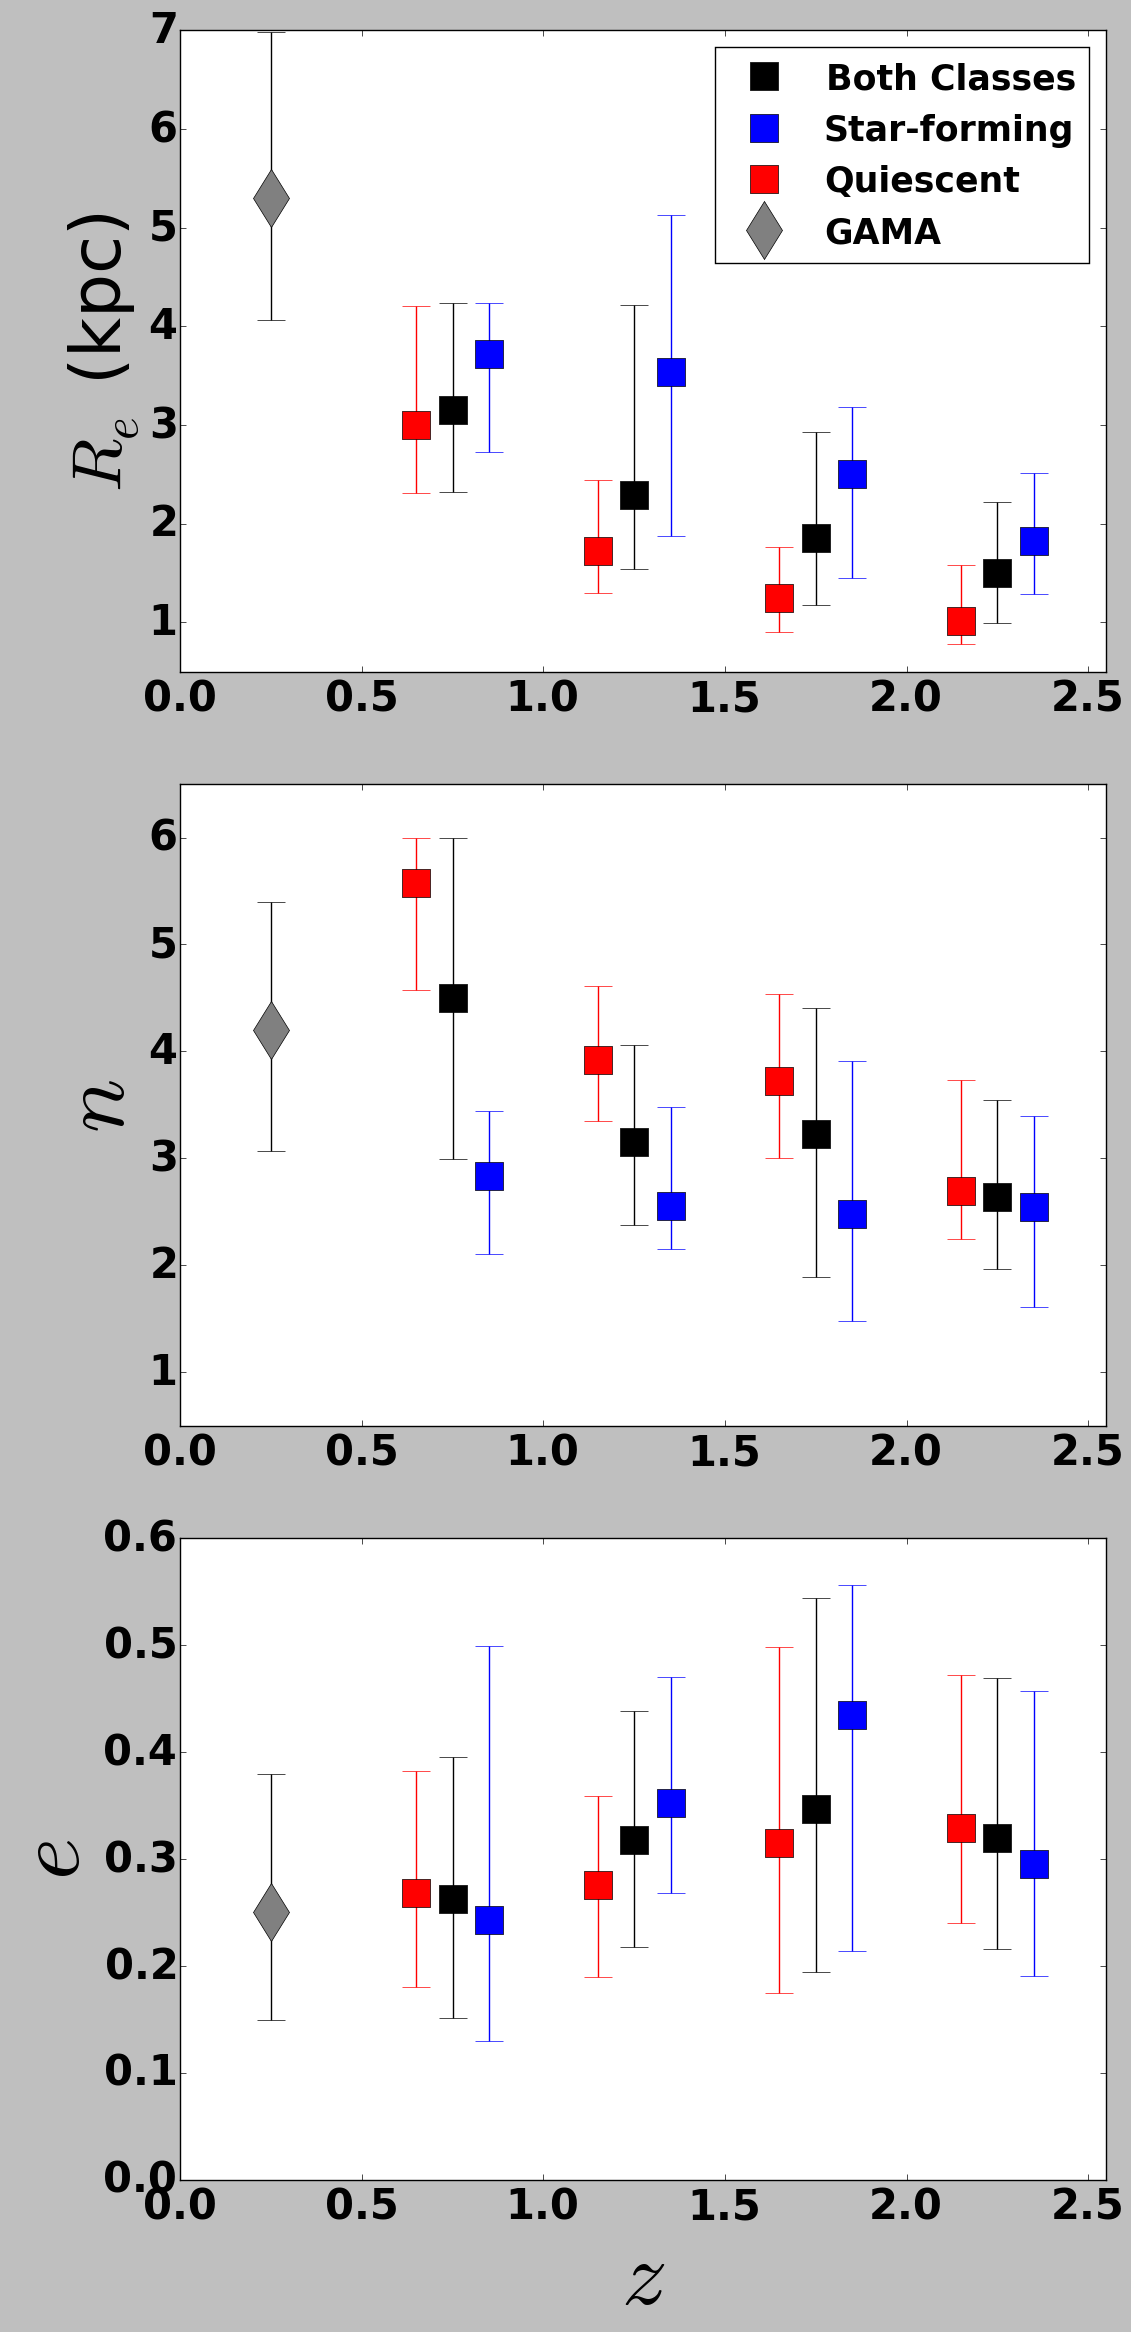

In [130]:
plot_singleSersic()

# Bulge + Disk Decomposition 

In [24]:
twoComp['Mag_b_cor'] = [row['Mag_b'] - 5*np.log10(cosmocalc(float(row['z']))['DL_Gyr']/cosmocalc(.1)['DL_Gyr']) 
                        for index,row in twoComp.iterrows() ]

twoComp['Mag_d_cor'] = [row['Mag_d'] - 5*np.log10(cosmocalc(float(row['z']))['DL_Gyr']/cosmocalc(.1)['DL_Gyr']) 
                        for index,row in twoComp.iterrows() ]

z05,z10,z15,z20 = four_bin(twoComp)

In [133]:
def plot_BT():
    
    #############################
    #### Setting Up The Plot ####
    #############################
    
    plt.rcdefaults()
    font = {'weight' : 'bold', 'size': 30}
    matplotlib.rc('font', **font)
    
    #plt.style.use('ggplot')
    
    gs = gridspec.GridSpec(3,1)
    plt.figure(figsize=(12,24))
    z = [0.75,1.25,1.75,2.25]

    #font = {'weight' : 'bold', 'size': 30}
    #matplotlib.rc('font', **font)
    # Adjusting the size of xlabel and ylabel
    plt.rcParams['font.size'] = 30

    
    ###########################
    #######  Re (kpc)  ########
    ###########################

    ax1 = plt.subplot(gs[0,:])
    
    all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(twoComp,'BT')
    
    # Adjusting the size of numbers on the axies
    plt.tick_params(axis='x', labelsize=30)
    plt.tick_params(axis='y', labelsize=30)
    ax1.set_xlim(0.45,2.55)
    ax1.set_ylim(0,1)
    ax1.set_ylabel('$B/T$',fontsize=50)
    
    ax1.plot(np.array(z),all,marker='s',color='black',linestyle='None',markersize=20,label='Both Classes')
    ax1.errorbar(np.array(z),all, yerr=[all_low,all_up], color='black', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)+.1,SF,marker='s',color='blue', linestyle='None',markersize=20,label='Star-forming')
    ax1.errorbar(np.array(z)+.1,SF, yerr=[SF_low,SF_up], color='blue', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)-.1,Que,marker='s',color='red', linestyle='None',markersize=20,label='Quiescent')
    ax1.errorbar(np.array(z)-.1,Que, yerr=[Que_low,Que_up], color='red', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.legend(loc='best', numpoints=1, ncol=1, fontsize=25)    
    
    ##################################
    #######  Bulge Magnitude  ########
    ##################################

    ax1 = plt.subplot(gs[1,:])
    
    all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(twoComp,'Mag_b_cor')
    
    plt.tick_params(axis='x', labelsize=30)
    plt.tick_params(axis='y', labelsize=30)
    ax1.set_xlim(0.45,2.55)
    ax1.set_ylim(17.2,14)
    ax1.set_yticks(range(14,18,1))
    ax1.set_ylabel('$m_{bulge}$ (mag)',fontsize=55)   
    
    ax1.plot(np.array(z),all,marker='s',color='black',linestyle='None',markersize=20)
    ax1.errorbar(np.array(z),all, yerr=[all_low,all_up], color='black', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)+.1,SF,marker='s',color='blue', linestyle='None',markersize=20)
    ax1.errorbar(np.array(z)+.1,SF, yerr=[SF_low,SF_up], color='blue', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)-.1,Que,marker='s',color='red', linestyle='None',markersize=20)
    ax1.errorbar(np.array(z)-.1,Que, yerr=[Que_low,Que_up], color='red', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)
    
    
    #################################
    #######  Disk Magnitude  ########
    #################################

    ax1 = plt.subplot(gs[2,:])
    
    all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(twoComp,'Mag_d_cor')
    
    plt.tick_params(axis='x', labelsize=30)
    plt.tick_params(axis='y', labelsize=30)
    ax1.set_xlim(0.45,2.55)
    ax1.set_ylim(16.3,14.15)
    ax1.set_yticks([14.5,15,15.5,16])
    ax1.set_xlabel('$z$',fontsize=65)
    ax1.set_ylabel('$m_{disk}$ (mag)',fontsize=55)
    
    ax1.plot(np.array(z),all,marker='s',color='black',linestyle='None',markersize=20)
    ax1.errorbar(np.array(z),all, yerr=[all_low,all_up], color='black', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)+.1,SF,marker='s',color='blue', linestyle='None',markersize=20)
    ax1.errorbar(np.array(z)+.1,SF, yerr=[SF_low,SF_up], color='blue', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)-.1,Que,marker='s',color='red', linestyle='None',markersize=20)
    ax1.errorbar(np.array(z)-.1,Que, yerr=[Que_low,Que_up], color='red', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)
    
    plt.tight_layout()

    plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Paper3/BT.ps')
    #plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Thesis/Sample/Chapter4/BT.pdf')

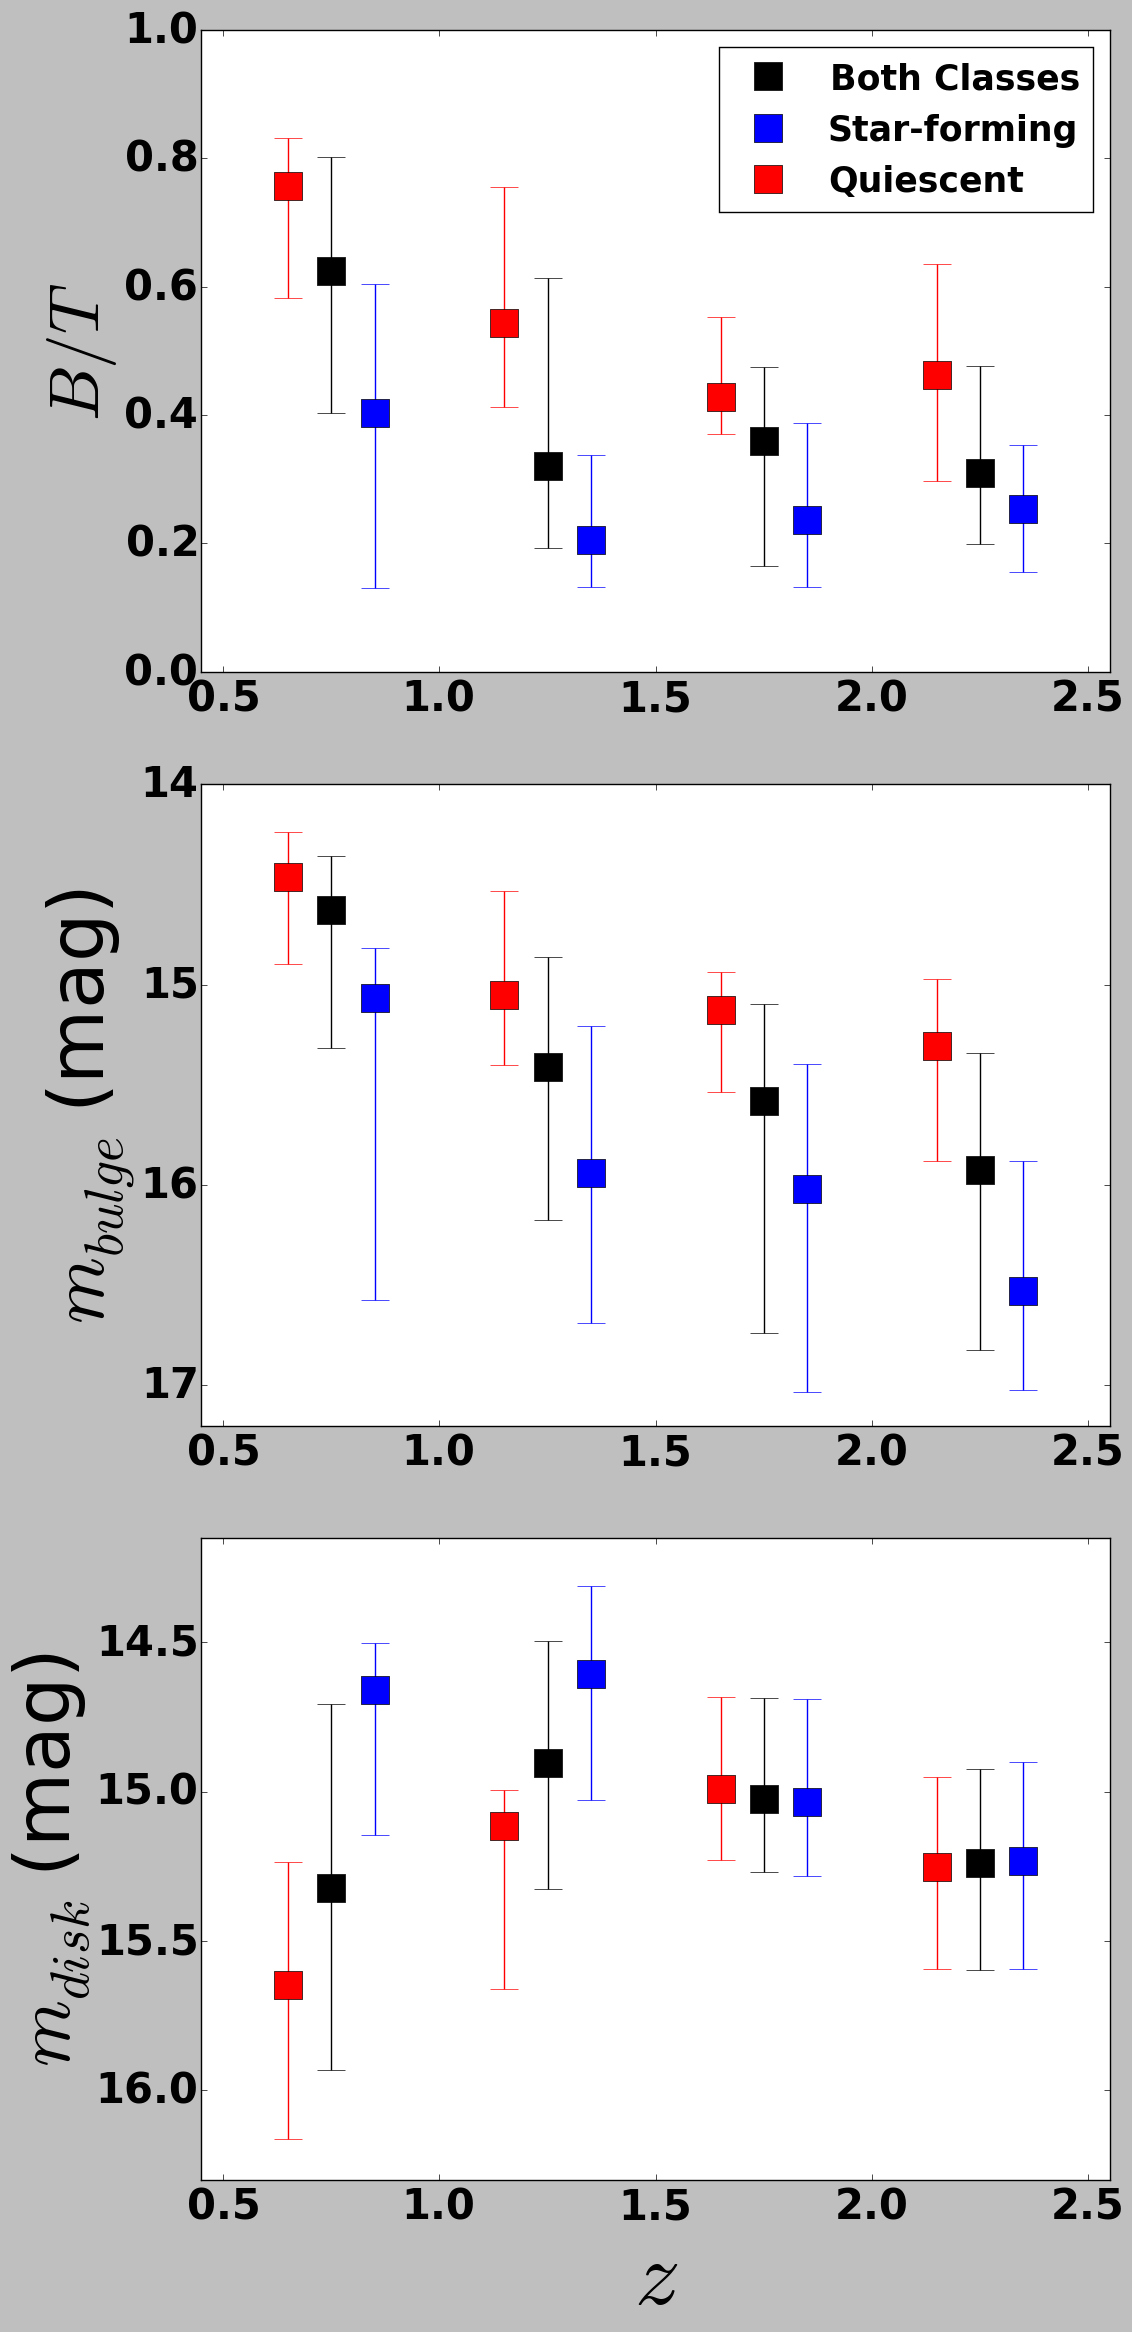

In [134]:
plot_BT()

In [135]:
def plot_Bulge():
    
    
    #############################
    #### Setting Up The Plot ####
    #############################
    
    plt.rcdefaults()
    font = {'weight' : 'bold', 'size': 30}
    matplotlib.rc('font', **font)
    #plt.style.use('ggplot')
    
    gs = gridspec.GridSpec(3,1)
    plt.figure(figsize=(12,24))
    z = [0.75,1.25,1.75,2.25]

    #font = {'weight' : 'bold', 'size': 30}
    #matplotlib.rc('font', **font)
    # Adjusting the size of xlabel and ylabel
    plt.rcParams['font.size'] = 30
 
    #################################
    #######  Re Bulge (kpc)  ########
    #################################

    ax1 = plt.subplot(gs[0,:])
    
    all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(twoComp,'Re_b_kpc')
    
    # Adjusting the size of numbers on the axies
    plt.tick_params(axis='x', labelsize=30)
    plt.tick_params(axis='y', labelsize=30)
    ax1.set_xlim(0.45,2.55)
    ax1.set_ylim(0,3)
    ax1.set_ylabel('$R_{e_{bulge}}$ (kpc)',fontsize=55)
    
    ax1.plot(np.array(z),all,marker='s',color='black',linestyle='None',markersize=20,label='Both Classes')
    ax1.errorbar(np.array(z),all, yerr=[all_low,all_up], color='black', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)+.1,SF,marker='s',color='blue', linestyle='None',markersize=20,label='Star-forming')
    ax1.errorbar(np.array(z)+.1,SF, yerr=[SF_low,SF_up], color='blue', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)-.1,Que,marker='s',color='red', linestyle='None',markersize=20,label='Quiescent')
    ax1.errorbar(np.array(z)-.1,Que, yerr=[Que_low,Que_up], color='red', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.legend(loc='best', numpoints=1, ncol=1, fontsize=25)         
    
    #####################################
    #######  Bulge Sersic Index  ########
    #####################################

    ax1 = plt.subplot(gs[1,:])
    
    all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(twoComp,'n_b')
    
    plt.tick_params(axis='x', labelsize=30)
    plt.tick_params(axis='y', labelsize=30)
    ax1.set_xlim(0.45,2.55)
    ax1.set_ylim(0,6)
    #ax1.set_yticks(range(20,26,2))
    ax1.set_ylabel('$n_{bulge}$',fontsize=65)
    
    ax1.plot(np.array(z),all,marker='s',color='black',linestyle='None',markersize=20)
    ax1.errorbar(np.array(z),all, yerr=[all_low,all_up], color='black', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)+.1,SF,marker='s',color='blue', linestyle='None',markersize=20)
    ax1.errorbar(np.array(z)+.1,SF, yerr=[SF_low,SF_up], color='blue', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)-.1,Que,marker='s',color='red', linestyle='None',markersize=20)
    ax1.errorbar(np.array(z)-.1,Que, yerr=[Que_low,Que_up], color='red', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)
    
    
    ####################################
    #######  Bulge Ellipticity  ########
    ####################################

    ax1 = plt.subplot(gs[2,:])
    
    all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(twoComp,'e_b')
    
    plt.tick_params(axis='x', labelsize=30)
    plt.tick_params(axis='y', labelsize=30)
    ax1.set_xlim(0.45,2.55)
    ax1.set_ylim(0,1)
    ax1.set_xlabel('$z$',fontsize=65)
    ax1.set_ylabel('$e_{bulge}$',fontsize=65)
    
    ax1.plot(np.array(z),all,marker='s',color='black',linestyle='None',markersize=20)
    ax1.errorbar(np.array(z),all, yerr=[all_low,all_up], color='black', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)+.1,SF,marker='s',color='blue', linestyle='None',markersize=20)
    ax1.errorbar(np.array(z)+.1,SF, yerr=[SF_low,SF_up], color='blue', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)-.1,Que,marker='s',color='red', linestyle='None',markersize=20)
    ax1.errorbar(np.array(z)-.1,Que, yerr=[Que_low,Que_up], color='red', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)
    
    plt.tight_layout()

    plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Paper3/Bulge.ps')
    #plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Thesis/Sample/Chapter4/Bulge.pdf')

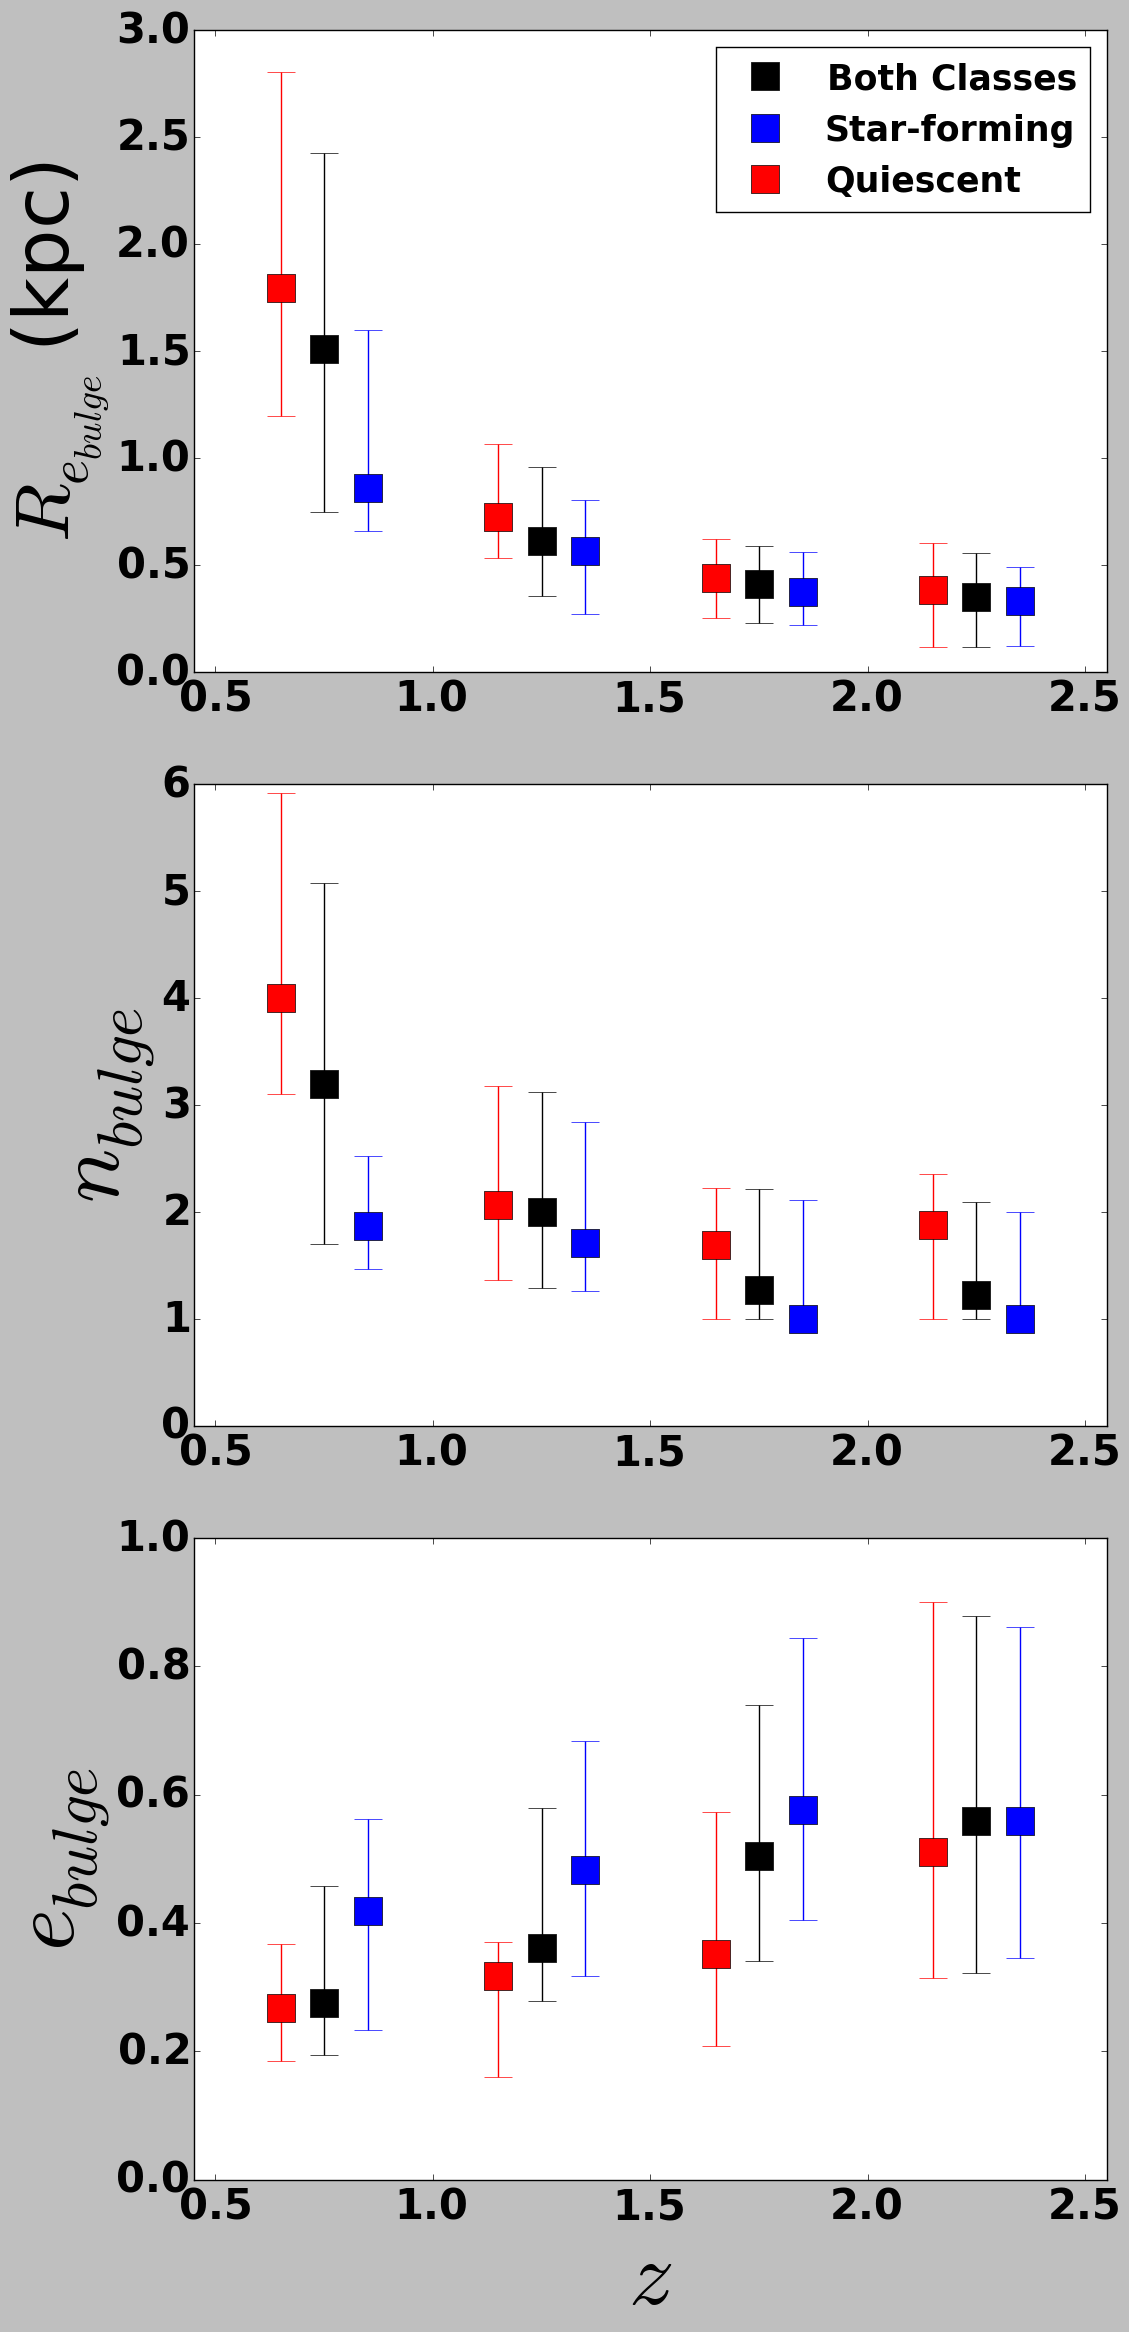

In [136]:
plot_Bulge()

In [137]:
def plot_Disk():
    
    
    #############################
    #### Setting Up The Plot ####
    #############################
    
    plt.rcdefaults()
    font = {'weight' : 'bold', 'size': 30}
    matplotlib.rc('font', **font)
    #plt.style.use('ggplot')
    
    gs = gridspec.GridSpec(2,1)
    plt.figure(figsize=(12,17))
    z = [0.75,1.25,1.75,2.25]

    #font = {'weight' : 'bold', 'size': 30}
    #matplotlib.rc('font', **font)
    # Adjusting the size of xlabel and ylabel
    plt.rcParams['font.size'] = 30
    
    
    ##########################################
    #######  Disk Scale Length (kpc)  ########
    ##########################################

    ax1 = plt.subplot(gs[0,:])
    
    all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(twoComp,'h_kpc')
    
    # Adjusting the size of numbers on the axies
    plt.tick_params(axis='x', labelsize=30)
    plt.tick_params(axis='y', labelsize=30)
    ax1.set_xlim(0.45,2.55)
    ax1.set_ylim(0.5,5)
    ax1.set_yticks(range(1,5,1))
    ax1.set_ylabel('$h$ (kpc)',fontsize=55)
    
    ax1.plot(np.array(z),all,marker='s',color='black',linestyle='None',markersize=20,label='Both Classes')
    ax1.errorbar(np.array(z),all, yerr=[all_low,all_up], color='black', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)+.1,SF,marker='s',color='blue', linestyle='None',markersize=20,label='Star-forming')
    ax1.errorbar(np.array(z)+.1,SF, yerr=[SF_low,SF_up], color='blue', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)-.1,Que,marker='s',color='red', linestyle='None',markersize=20,label='Quiescent')
    ax1.errorbar(np.array(z)-.1,Que, yerr=[Que_low,Que_up], color='red', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.legend(loc='best', numpoints=1, ncol=1, fontsize=25)     
    
    ###################################
    #######  Disk Ellipticity  ########
    ###################################

    ax1 = plt.subplot(gs[1,:])
    
    all,all_low,all_up,SF,SF_low,SF_up,Que,Que_low,Que_up = medians_and_err(twoComp,'e_d')
    
    plt.tick_params(axis='x', labelsize=30)
    plt.tick_params(axis='y', labelsize=30)
    ax1.set_xlim(0.45,2.55)
    ax1.set_ylim(0,.6)
    ax1.set_xlabel('$z$',fontsize=65)
    ax1.set_ylabel('$e_{disk}$',fontsize=65)
    
    ax1.plot(np.array(z),all,marker='s',color='black',linestyle='None',markersize=20)
    ax1.errorbar(np.array(z),all, yerr=[all_low,all_up], color='black', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)+.1,SF,marker='s',color='blue', linestyle='None',markersize=20)
    ax1.errorbar(np.array(z)+.1,SF, yerr=[SF_low,SF_up], color='blue', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

    ax1.plot(np.array(z)-.1,Que,marker='s',color='red', linestyle='None',markersize=20)
    ax1.errorbar(np.array(z)-.1,Que, yerr=[Que_low,Que_up], color='red', marker='.', 
                     elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)
    
    plt.tight_layout()

    plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Paper3/Disk.ps')
    #plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Thesis/Sample/Chapter4/Disk.pdf')

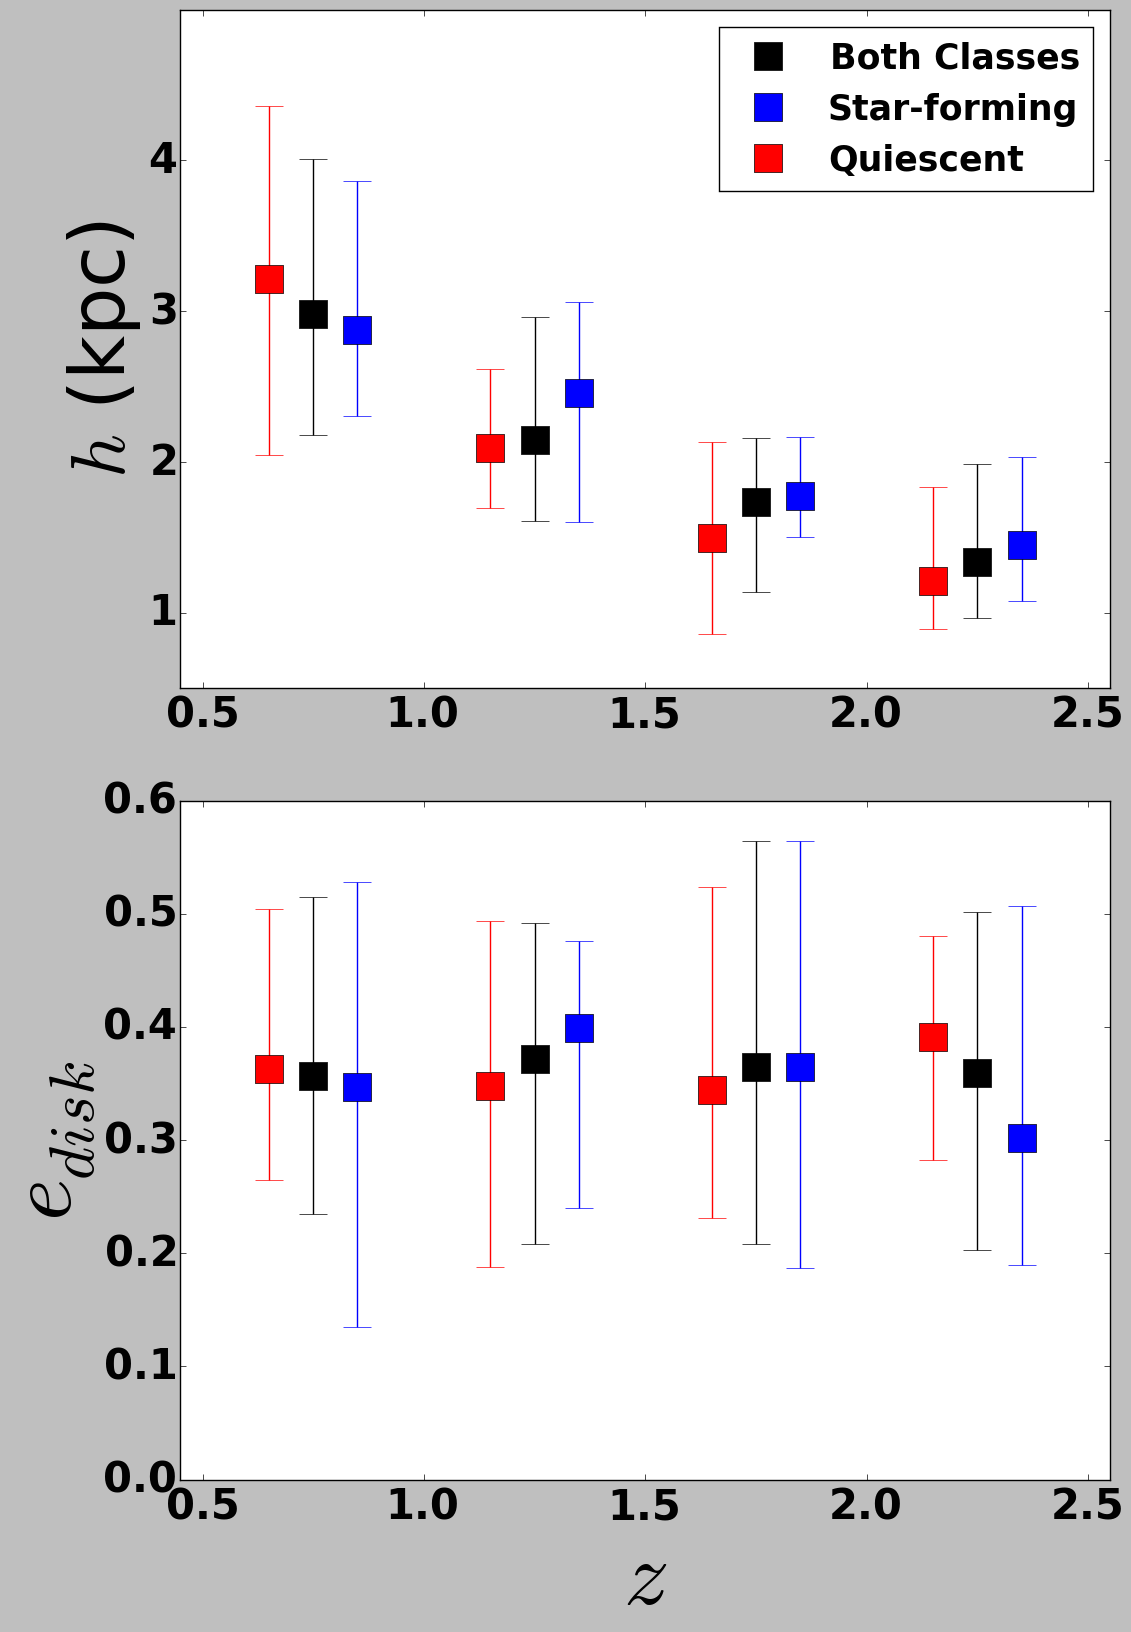

In [138]:
plot_Disk()

# Sky Component

median sky_dff:  -8.61e-05


(array([  3.,   7.,   4.,   2.,   6.,  14.,  18.,  20.,  28.,  36.,  22.,
         15.,  13.,   9.,   5.,   1.,   2.,   5.,   4.,   4.]),
 array([ -1.00000000e-03,  -9.00000000e-04,  -8.00000000e-04,
         -7.00000000e-04,  -6.00000000e-04,  -5.00000000e-04,
         -4.00000000e-04,  -3.00000000e-04,  -2.00000000e-04,
         -1.00000000e-04,   0.00000000e+00,   1.00000000e-04,
          2.00000000e-04,   3.00000000e-04,   4.00000000e-04,
          5.00000000e-04,   6.00000000e-04,   7.00000000e-04,
          8.00000000e-04,   9.00000000e-04,   1.00000000e-03]),
 <a list of 20 Patch objects>)

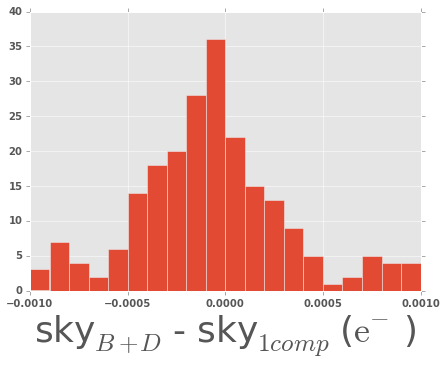

In [14]:
sky_diff = twoComp.sky_2ser - singleSer.sky_1ser
print 'median sky_dff: ', np.median(sky_diff.dropna())

plt.figure(figsize=(7,5))
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
font = {'weight' : 'bold', 'size': 20}
plt.xlabel('sky$_{B+D}$ - sky$_{1comp}$ ($\mathrm{e^-}$)')
plt.hist(sky_diff.dropna(),bins=20,range=(-0.001,0.001))

# Fraction of SF and Quiescent Galaxies 

In [139]:
singleSer = pd.read_csv('../SM/1comp.csv')
#plt.style.use('ggplot')

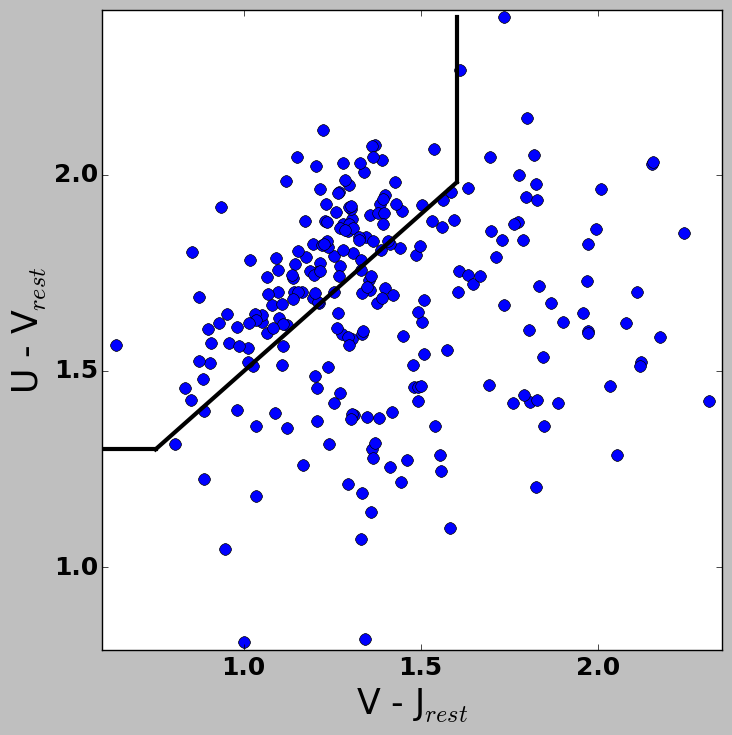

In [152]:
plt.rcdefaults()
font = {'weight' : 'bold', 'size': 30}
matplotlib.rc('font', **font)

plt.figure(figsize=(8,8))
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xlim(0.6,2.35)
plt.ylim(0.79,2.42)
#plt.yticks([0.1,0.3,0.5,0.7])
plt.xlabel('V - J$_{rest}$',fontsize=25)
plt.ylabel('U - V$_{rest}$',fontsize=25)

plt.plot(singleSer['V']-singleSer['J'],singleSer['U']-singleSer['V'],
         marker='o',linestyle='None',markersize=8)
plt.plot((0.6, 0.75), (1.3, 1.3), 'k-',linewidth = 3)
plt.plot((1.6, 1.6), (1.98, 2.4), 'k-',linewidth = 3)
plt.plot((0.75,1.6), (1.3, 1.98), 'k-',linewidth = 3)

plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Paper3/UVJ.ps')
#plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Thesis/Davari/Chapter4/UVJ.pdf')

In [142]:
def binomial_err(p,n):
    return np.sqrt((p*(1-p))/n)

def number_per_class(cat,Type):
    return cat[cat['SF1_Quies0'] == Type].shape[0]

z05,z10,z15,z20 = four_bin(singleSer,lim1=1,lim2=1.5,lim3=2)

z05_sf = number_per_class(z05,1) / float(z05.shape[0])
z05_sf_err = binomial_err(z05_sf,number_per_class(z05,1))
z05_qui = number_per_class(z05,0) / float(z05.shape[0])
z05_qui_err = binomial_err(z05_qui,number_per_class(z05,0))

z10_sf = number_per_class(z10,1) / float(z10.shape[0])
z10_sf_err = binomial_err(z10_sf,number_per_class(z10,1))
z10_qui = number_per_class(z10,0) / float(z10.shape[0])
z10_qui_err = binomial_err(z10_qui,number_per_class(z10,0))

z15_sf = number_per_class(z15,1) / float(z15.shape[0])
z15_sf_err = binomial_err(z15_sf,number_per_class(z15,1))
z15_qui = number_per_class(z15,0) / float(z15.shape[0])
z15_qui_err = binomial_err(z15_qui,number_per_class(z15,0))

z20_sf = z20[z20.SF1_Quies0 == 1].shape[0] / float(z20.shape[0])
z20_sf_err = binomial_err(z20_sf,number_per_class(z20,1))
z20_qui = z20[z20.SF1_Quies0 == 0].shape[0] / float(z20.shape[0])
z20_qui_err = binomial_err(z20_qui,number_per_class(z20,0))

SF_fraction = [z05_sf,z10_sf,z15_sf,z20_sf]
SF_fraction_err = [z05_sf_err,z10_sf_err,z15_sf_err,z20_sf_err]
QUI_fraction = [z05_qui,z10_qui,z15_qui,z20_qui]
QUI_fraction_err = [z05_qui_err,z10_qui_err,z15_qui_err,z20_qui_err]

In [143]:
print QUI_fraction
print QUI_fraction_err

[0.6774193548387096, 0.45098039215686275, 0.3707865168539326, 0.4155844155844156]
[0.10200895677962514, 0.10375495337508199, 0.084082188466830146, 0.087119531590900898]


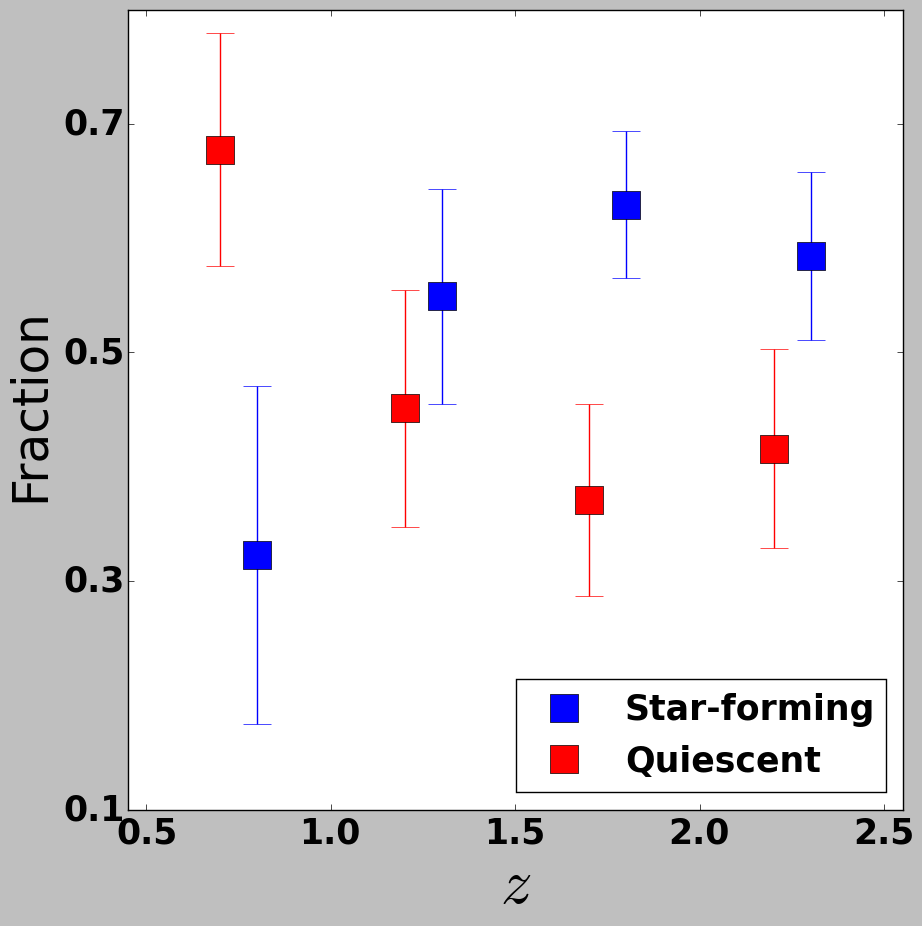

In [153]:
plt.rcdefaults()
font = {'weight' : 'bold', 'size': 30}
matplotlib.rc('font', **font)
#plt.style.use('ggplot')
    
z = [0.75,1.25,1.75,2.25]
    
plt.figure(figsize=(10,10))
#font = {'weight' : 'bold', 'size': 20}
matplotlib.rc('font', **font)
# Adjusting the size of xlabel and ylabel
plt.rcParams['font.size'] = 20
#plt.style.use('ggplot')

plt.plot(np.array(z)+.05,SF_fraction,marker='s',color='blue', 
         linestyle='None',markersize=20, label='Star-forming')
plt.errorbar(np.array(z)+.05,SF_fraction, yerr=SF_fraction_err, color='blue', marker='.', 
                 elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

plt.plot(np.array(z)-.05,QUI_fraction,marker='s',color='red',
         linestyle='None',markersize=20, label='Quiescent')
plt.errorbar(np.array(z)-.05,QUI_fraction, yerr=QUI_fraction_err, color='red', marker='.', 
                 elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

plt.legend(loc='lower right', numpoints=1, ncol=1, fontsize=25)

plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
plt.xlim(0.45,2.55)
plt.ylim(0.1,.8)
plt.yticks([0.1,0.3,0.5,0.7])
plt.xlabel('$z$',fontsize=45)
plt.ylabel('Fraction',fontsize=35)

plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Paper3/Fraction_SF_Quie.ps')
#plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Thesis/Davari/Chapter4/Fraction_SF_Quie.pdf')


# Fraction of Spiral Strcutures & Merger for Each Type 

## Preparing Catalogue 

In [262]:
z05_minor_cer,z05_minor_uncer,z05_major_cer,z05_major_uncer=[],[],[],[]
z05_arm_cer,z05_arm_uncer,z05_ring_cer,z05_ring_uncer,z05_bar_cer,z05_bar_uncer=[],[],[],[],[],[]

z10_minor_cer,z10_minor_uncer,z10_major_cer,z10_major_uncer=[],[],[],[]
z10_arm_cer,z10_arm_uncer,z10_ring_cer,z10_ring_uncer,z10_bar_cer,z10_bar_uncer=[],[],[],[],[],[]

z15_minor_cer,z15_minor_uncer,z15_major_cer,z15_major_uncer=[],[],[],[]
z15_arm_cer,z15_arm_uncer,z15_ring_cer,z15_ring_uncer,z15_bar_cer,z15_bar_uncer=[],[],[],[],[],[]

z20_minor_cer,z20_minor_uncer,z20_major_cer,z20_major_uncer=[],[],[],[]
z20_arm_cer,z20_arm_uncer,z20_ring_cer,z20_ring_uncer,z20_bar_cer,z20_bar_uncer=[],[],[],[],[],[]

checked = []


cat_dict = {'z05_minor_cer':z05_minor_cer,'z05_minor_uncer':z05_minor_uncer,
            'z05_major_cer':z05_major_cer,'z05_major_uncer':z05_major_uncer,
            'z05_arm_cer':z05_arm_cer,'z05_arm_uncer':z05_arm_uncer,
            'z05_ring_cer':z05_ring_cer,'z05_ring_uncer':z05_ring_uncer,
            'z05_bar_cer':z05_bar_cer,'z05_bar_uncer':z05_bar_uncer,
            'z10_minor_cer':z10_minor_cer,'z10_minor_uncer':z10_minor_uncer,
            'z10_major_cer':z10_major_cer,'z10_major_uncer':z10_major_uncer,
            'z10_arm_cer':z10_arm_cer,'z10_arm_uncer':z10_arm_uncer,
            'z10_ring_cer':z10_ring_cer,'z10_ring_uncer':z10_ring_uncer,
            'z10_bar_cer':z10_bar_cer,'z10_bar_uncer':z10_bar_uncer,
            'z15_minor_cer':z15_minor_cer,'z15_minor_uncer':z15_minor_uncer,
            'z15_major_cer':z15_major_cer,'z15_major_uncer':z15_major_uncer,
            'z15_arm_cer':z15_arm_cer,'z15_arm_uncer':z15_arm_uncer,
            'z15_ring_cer':z15_ring_cer,'z15_ring_uncer':z15_ring_uncer,
            'z15_bar_cer':z15_bar_cer,'z15_bar_uncer':z15_bar_uncer,
            'z20_minor_cer':z20_minor_cer,'z20_minor_uncer':z20_minor_uncer,
            'z20_major_cer':z20_major_cer,'z20_major_uncer':z20_major_uncer,
            'z20_arm_cer':z20_arm_cer,'z20_arm_uncer':z20_arm_uncer,
            'z20_ring_cer':z20_ring_cer,'z20_ring_uncer':z20_ring_uncer,
            'z20_bar_cer':z20_bar_cer,'z20_bar_uncer':z20_bar_uncer,}

## Interactively Categorizing

In [347]:
# oneSer = pd.read_csv('../SM/2comp.csv')

for galaxy in sorted(oneSer.Name.values):

    
    ###################
    ### If already categorized then move to the next object
    ###################
    if galaxy in checked:
        continue    
    
    cat = oneSer[oneSer.Name == galaxy]
    z = float(cat['z'])
    SF_class = int(cat['SF1_Quies0'])
    n = float(cat['n'])
    
    print galaxy, ['Quiescent','Star Forming'][SF_class],'z='+str(z), 'n='+str(n),cat['note']

    if z <= 1:
        z_symb = 'z05'
    elif z <= 1.5:
        z_symb = 'z10'
    elif z <= 2:
        z_symb = 'z15'
    else:
        z_symb = 'z20'
    
    ##################
    ### If bulge+disk failer --> open 1comp results
    ##################
    
    os.system('ds9 -multiframe -scale log ' + PATH + 'Fits/2comp/' + galaxy[:-4] + '_2ser.fit &')        
    
    Type = raw_input('What type? (merger/spiral/both): ')
    

    #########################
    ######## Mergers ########
    #########################
    
    if Type.lower() == 'merger':
        
        mergerType = raw_input('merger type? (major/minor): ')
        
        if mergerType.lower() == 'minor':
            if int(raw_input('Are you certain (0/1): ')):
                cat_dict[z_symb + '_minor_cer'].append(galaxy)
            else:
                cat_dict[z_symb + '_minor_uncer'].append(galaxy)
        
        elif mergerType.lower() == 'major':
            if int(raw_input('Are you certain (0/1): ')):
                cat_dict[z_symb + '_major_cer'].append(galaxy)
            else:
                cat_dict[z_symb + '_major_uncer'].append(galaxy) 
        
        else:
            raise 'What type of merger you said?!'
            
            
    ###################################
    ######## Spiral Structures ########
    ###################################
    
    elif Type.lower() == 'spiral':
        
        spiralStructure = raw_input('spiral structure type? (arm/ring/bar): ')
        
        if spiralStructure.lower() == 'arm':
            if int(raw_input('Are you certain (0/1): ')):
                cat_dict[z_symb + '_arm_cer'].append(galaxy)
            else:
                cat_dict[z_symb + '_arm_uncer'].append(galaxy)
        
        elif spiralStructure.lower() == 'ring':
            if int(raw_input('Are you certain (0/1): ')):
                cat_dict[z_symb + '_ring_cer'].append(galaxy)
            else:
                cat_dict[z_symb + '_ring_uncer'].append(galaxy) 

        elif spiralStructure.lower() == 'bar':
            if int(raw_input('Are you certain (0/1): ')):
                cat_dict[z_symb + '_bar_cer'].append(galaxy)
            else:
                cat_dict[z_symb + '_bar_uncer'].append(galaxy)
                
        else:
            raise 'What type of spiral structure you said?!'

            
    ######################
    ######## Both ########
    ######################

    elif Type.lower() == 'both':

        mergerType = raw_input('merger type? (major/minor): ')
        
        if mergerType.lower() == 'minor':
            if int(raw_input('Are you certain (0/1): ')):
                cat_dict[z_symb + '_minor_cer'].append(galaxy)
            else:
                cat_dict[z_symb + '_minor_uncer'].append(galaxy)
        
        elif mergerType.lower() == 'major':
            if int(raw_input('Are you certain (0/1): ')):
                cat_dict[z_symb + '_major_cer'].append(galaxy)
            else:
                cat_dict[z_symb + '_major_uncer'].append(galaxy) 
        
        else:
            raise 'What type of merger you said?!'
            
            
        spiralStructure = raw_input('spiral structure type? (arm/ring/bar): ')
        
        if spiralStructure.lower() == 'arm':
            if int(raw_input('Are you certain (0/1): ')):
                cat_dict[z_symb + '_arm_cer'].append(galaxy)
            else:
                cat_dict[z_symb + '_arm_uncer'].append(galaxy)
        
        elif spiralStructure.lower() == 'ring':
            if int(raw_input('Are you certain (0/1): ')):
                cat_dict[z_symb + '_ring_cer'].append(galaxy)
            else:
                cat_dict[z_symb + '_ring_uncer'].append(galaxy) 

        elif spiralStructure.lower() == 'bar':
            if int(raw_input('Are you certain (0/1): ')):
                cat_dict[z_symb + '_bar_cer'].append(galaxy)
            else:
                cat_dict[z_symb + '_bar_uncer'].append(galaxy)
                
        else:
            raise 'What type of spiral structure you said?!'
    

    checked.append(galaxy)

## Saving The Results 

In [158]:
import json
#json.dump(cat_dict,open("merger_spiral.txt",'w'))
cat_dict = json.load(open("merger_spiral.txt"))
cat_dict

{u'z05_arm_cer': [u'z0.7_m11.1_13815.0_cosmos_drz',
  u'z1.0_m11.0_24815.0_egs_drz',
  u'z1.0_m11.1_18285_uds_drz'],
 u'z05_arm_uncer': [],
 u'z05_bar_cer': [],
 u'z05_bar_uncer': [],
 u'z05_major_cer': [u'z1.0_m11.2_10391.0_gs_drz'],
 u'z05_major_uncer': [u'z0.8_m11.2_14854.0_egs_drz',
  u'z0.9_m11.1_21168.0_gs_drz',
  u'z0.9_m11.2_1272.0_cosmos_drz',
  u'z1.0_m11.1_7447.0_cosmos_drz'],
 u'z05_minor_cer': [u'z0.6_m11.1_11494_uds_drz',
  u'z0.6_m11.1_16306_gn_drz',
  u'z0.6_m11.1_8151_uds_drz',
  u'z0.6_m11.2_10713_uds_drz',
  u'z0.7_m11.0_15086_uds_drz',
  u'z0.7_m11.0_15700.0_cosmos_drz',
  u'z0.7_m11.1_16563.0_cosmos_drz',
  u'z0.7_m11.1_22369.0_gs_drz',
  u'z0.8_m11.0_17014_gn_drz',
  u'z0.8_m11.0_27293.0_cosmos_drz',
  u'z0.8_m11.1_23856_gn_drz',
  u'z0.8_m11.1_8829_gn_drz',
  u'z0.8_m11.2_11733_uds_drz',
  u'z0.8_m11.2_8164.0_egs_drz',
  u'z0.9_m11.0_22228.0_cosmos_drz',
  u'z0.9_m11.1_17831.0_cosmos_drz',
  u'z0.9_m11.1_27072.0_cosmos_drz',
  u'z0.9_m11.1_6645_gn_drz'],
 u'z05_m

## Merger Fraction

### Ploting Mergers 

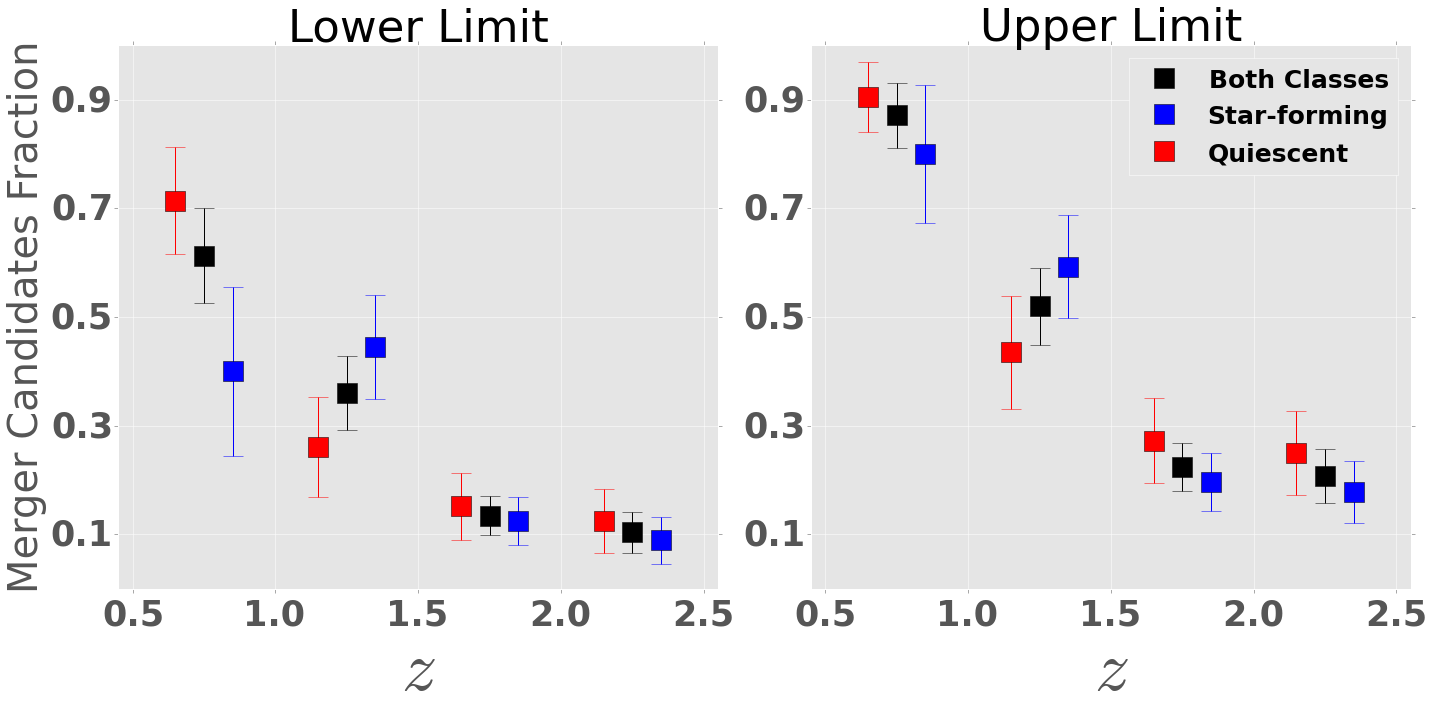

In [254]:
twoComp = pd.read_csv('../SM/2comp.csv')

gs = gridspec.GridSpec(1,2)
plt.figure(figsize=(20,10))
font = {'weight' : 'bold', 'size': 20}
matplotlib.rc('font', **font)
# Adjusting the size of xlabel and ylabel
plt.rcParams['font.size'] = 20
plt.style.use('ggplot')

#############################
####### Lower Limit #########
#############################

ax1 = plt.subplot(gs[:,0])

z05_merger_cer = cat_dict['z05_major_cer'] + cat_dict['z05_minor_cer'] 
z10_merger_cer = cat_dict['z10_major_cer'] + cat_dict['z10_minor_cer'] 
z15_merger_cer = cat_dict['z15_major_cer'] + cat_dict['z15_minor_cer'] 
z20_merger_cer = cat_dict['z20_major_cer'] + cat_dict['z20_minor_cer']
z05_merger_SF, z05_merger_Que, z05_SF, z05_Que = 0.0, 0.0, 0.0, 0.0
z10_merger_SF, z10_merger_Que, z10_SF, z10_Que = 0.0, 0.0, 0.0, 0.0
z15_merger_SF, z15_merger_Que, z15_SF, z15_Que = 0.0, 0.0, 0.0, 0.0
z20_merger_SF, z20_merger_Que, z20_SF, z20_Que = 0.0, 0.0, 0.0, 0.0

for name in z05_merger_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z05_merger_SF += 1
    else:
        z05_merger_Que += 1       
for name in z10_merger_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z10_merger_SF += 1
    else:
        z10_merger_Que += 1
for name in z15_merger_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z15_merger_SF += 1
    else:
        z15_merger_Que += 1
for name in z20_merger_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z20_merger_SF += 1
    else:
        z20_merger_Que += 1
        
for name in np.array(z05.Name.values):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z05_SF += 1
    else:
        z05_Que += 1
for name in np.array(z10.Name.values):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z10_SF += 1
    else:
        z10_Que += 1
for name in np.array(z15.Name.values):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z15_SF += 1
    else:
        z15_Que += 1
for name in np.array(z20.Name.values):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z20_SF += 1
    else:
        z20_Que += 1

p05_SF, p05_Que, p05_both = z05_merger_SF/z05_SF,z05_merger_Que/z05_Que,(z05_merger_SF+z05_merger_Que)/(z05_Que+z05_SF)
p10_SF, p10_Que, p10_both = z10_merger_SF/z10_SF,z10_merger_Que/z10_Que,(z10_merger_SF+z10_merger_Que)/(z10_Que+z10_SF)
p15_SF, p15_Que, p15_both = z15_merger_SF/z15_SF,z15_merger_Que/z15_Que,(z15_merger_SF+z15_merger_Que)/(z15_Que+z15_SF)
p20_SF, p20_Que, p20_both = z20_merger_SF/z20_SF,z20_merger_Que/z20_Que,(z20_merger_SF+z20_merger_Que)/(z20_Que+z20_SF)

p05_SF_err,p05_Que_err,p05_both_err = binomial_err(p05_SF,z05_SF),binomial_err(p05_Que,z05_Que),binomial_err(p05_both,z05_Que+z05_SF)
p10_SF_err,p10_Que_err,p10_both_err = binomial_err(p10_SF,z10_SF),binomial_err(p10_Que,z10_Que),binomial_err(p10_both,z10_Que+z10_SF)
p15_SF_err,p15_Que_err,p15_both_err = binomial_err(p15_SF,z15_SF),binomial_err(p15_Que,z15_Que),binomial_err(p15_both,z15_Que+z15_SF)
p20_SF_err,p20_Que_err,p20_both_err = binomial_err(p20_SF,z20_SF),binomial_err(p20_Que,z20_Que),binomial_err(p20_both,z05_Que+z20_SF)

SF_fraction = [p05_SF,p10_SF,p15_SF,p20_SF]
QUI_fraction = [p05_Que,p10_Que,p15_Que,p20_Que]
both_fraction = [p05_both,p10_both,p15_both,p20_both]
SF_fraction_err = [p05_SF_err,p10_SF_err,p15_SF_err,p20_SF_err]
QUI_fraction_err = [p05_Que_err,p10_Que_err,p15_Que_err,p20_Que_err]
both_fraction_err = [p05_both_err,p10_both_err,p15_both_err,p20_both_err]

z = [0.75,1.25,1.75,2.25]
plt.tick_params(axis='x', labelsize=35)
plt.tick_params(axis='y', labelsize=35)
ax1.set_xlim(0.45,2.55)
ax1.set_ylim(0,1)
ax1.set_yticks([0.1,0.3,0.5,0.7,0.9])
ax1.set_xlabel('$z$',fontsize=70)
ax1.set_ylabel('Merger Candidates Fraction',fontsize=40)
ax1.set_title('Lower Limit',fontsize=45)

ax1.plot(np.array(z),both_fraction,marker='s',color='black',
         linestyle='None',markersize=20, label='Both Classes')
ax1.errorbar(np.array(z),both_fraction, yerr=both_fraction_err, color='black', marker='.', 
                 elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

ax1.plot(np.array(z)+.1,SF_fraction,marker='s',color='blue', 
         linestyle='None',markersize=20, label='Star-forming')
ax1.errorbar(np.array(z)+.1,SF_fraction, yerr=SF_fraction_err, color='blue', marker='.', 
                 elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

ax1.plot(np.array(z)-.1,QUI_fraction,marker='s',color='red',
         linestyle='None',markersize=20, label='Quiescent')
ax1.errorbar(np.array(z)-.1,QUI_fraction, yerr=QUI_fraction_err, color='red', marker='.', 
                 elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

#############################
####### Upper Limit #########
#############################

ax2 = plt.subplot(gs[:,1])

z05_merger_cer = cat_dict['z05_major_cer'] + cat_dict['z05_minor_cer'] + cat_dict['z05_major_uncer'] + cat_dict['z05_minor_uncer']
z10_merger_cer = cat_dict['z10_major_cer'] + cat_dict['z10_minor_cer'] + cat_dict['z05_major_uncer'] + cat_dict['z05_minor_uncer']
z15_merger_cer = cat_dict['z15_major_cer'] + cat_dict['z15_minor_cer'] + cat_dict['z05_major_uncer'] + cat_dict['z05_minor_uncer']
z20_merger_cer = cat_dict['z20_major_cer'] + cat_dict['z20_minor_cer'] + cat_dict['z05_major_uncer'] + cat_dict['z05_minor_uncer']
z05_merger_SF, z05_merger_Que, z05_SF, z05_Que = 0.0, 0.0, 0.0, 0.0
z10_merger_SF, z10_merger_Que, z10_SF, z10_Que = 0.0, 0.0, 0.0, 0.0
z15_merger_SF, z15_merger_Que, z15_SF, z15_Que = 0.0, 0.0, 0.0, 0.0
z20_merger_SF, z20_merger_Que, z20_SF, z20_Que = 0.0, 0.0, 0.0, 0.0

for name in z05_merger_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z05_merger_SF += 1
    else:
        z05_merger_Que += 1       
for name in z10_merger_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z10_merger_SF += 1
    else:
        z10_merger_Que += 1
for name in z15_merger_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z15_merger_SF += 1
    else:
        z15_merger_Que += 1
for name in z20_merger_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z20_merger_SF += 1
    else:
        z20_merger_Que += 1
        
for name in np.array(z05.Name.values):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z05_SF += 1
    else:
        z05_Que += 1
for name in np.array(z10.Name.values):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z10_SF += 1
    else:
        z10_Que += 1
for name in np.array(z15.Name.values):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z15_SF += 1
    else:
        z15_Que += 1
for name in np.array(z20.Name.values):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z20_SF += 1
    else:
        z20_Que += 1

p05_SF, p05_Que, p05_both = z05_merger_SF/z05_SF,z05_merger_Que/z05_Que,(z05_merger_SF+z05_merger_Que)/(z05_Que+z05_SF)
p10_SF, p10_Que, p10_both = z10_merger_SF/z10_SF,z10_merger_Que/z10_Que,(z10_merger_SF+z10_merger_Que)/(z10_Que+z10_SF)
p15_SF, p15_Que, p15_both = z15_merger_SF/z15_SF,z15_merger_Que/z15_Que,(z15_merger_SF+z15_merger_Que)/(z15_Que+z15_SF)
p20_SF, p20_Que, p20_both = z20_merger_SF/z20_SF,z20_merger_Que/z20_Que,(z20_merger_SF+z20_merger_Que)/(z20_Que+z20_SF)

p05_SF_err,p05_Que_err,p05_both_err = binomial_err(p05_SF,z05_SF),binomial_err(p05_Que,z05_Que),binomial_err(p05_both,z05_Que+z05_SF)
p10_SF_err,p10_Que_err,p10_both_err = binomial_err(p10_SF,z10_SF),binomial_err(p10_Que,z10_Que),binomial_err(p10_both,z10_Que+z10_SF)
p15_SF_err,p15_Que_err,p15_both_err = binomial_err(p15_SF,z15_SF),binomial_err(p15_Que,z15_Que),binomial_err(p15_both,z15_Que+z15_SF)
p20_SF_err,p20_Que_err,p20_both_err = binomial_err(p20_SF,z20_SF),binomial_err(p20_Que,z20_Que),binomial_err(p20_both,z05_Que+z20_SF)

SF_fraction = [p05_SF,p10_SF,p15_SF,p20_SF]
QUI_fraction = [p05_Que,p10_Que,p15_Que,p20_Que]
both_fraction = [p05_both,p10_both,p15_both,p20_both]
SF_fraction_err = [p05_SF_err,p10_SF_err,p15_SF_err,p20_SF_err]
QUI_fraction_err = [p05_Que_err,p10_Que_err,p15_Que_err,p20_Que_err]
both_fraction_err = [p05_both_err,p10_both_err,p15_both_err,p20_both_err]

z = [0.75,1.25,1.75,2.25]

plt.tick_params(axis='x', labelsize=35)
plt.tick_params(axis='y', labelsize=35)
ax2.set_xlim(0.45,2.55)
ax2.set_ylim(0,1)
ax2.set_yticks([0.1,0.3,0.5,0.7,0.9])
ax2.set_xlabel('$z$',fontsize=70)
ax2.set_title('Upper Limit',fontsize=45)

ax2.plot(np.array(z),both_fraction,marker='s',color='black',
         linestyle='None',markersize=20, label='Both Classes')
ax2.errorbar(np.array(z),both_fraction, yerr=both_fraction_err, color='black', marker='.', 
                 elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

ax2.plot(np.array(z)+.1,SF_fraction,marker='s',color='blue', 
         linestyle='None',markersize=20, label='Star-forming')
ax2.errorbar(np.array(z)+.1,SF_fraction, yerr=SF_fraction_err, color='blue', marker='.', 
                 elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

ax2.plot(np.array(z)-.1,QUI_fraction,marker='s',color='red',
         linestyle='None',markersize=20, label='Quiescent')
ax2.errorbar(np.array(z)-.1,QUI_fraction, yerr=QUI_fraction_err, color='red', marker='.', 
                 elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

ax2.legend(loc='best', numpoints=1, ncol=1, fontsize=25)


plt.tight_layout()

plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Paper3/Merger_Fraction.ps')
plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Thesis/Sample/Chapter4/Merger_Fraction.pdf')

## Spiral Structure 

In [33]:
str(cat_dict['z15_ring_cer'] + cat_dict['z15_arm_cer'])

"[u'z1.7_m11.0_2067_uds_drz', u'z1.5_m11.0_27211_gn_drz', u'z1.5_m11.1_11334.0_egs_drz', u'z1.6_m10.9_4161.0_gs_drz', u'z1.6_m11.0_9375.0_egs_drz', u'z1.7_m10.9_17116_gn_drz', u'z1.7_m10.9_25604.0_egs_drz', u'z1.8_m10.9_8297_uds_drz', u'z1.9_m10.9_8531_uds_drz', u'z2.0_m10.9_7184.0_gs_drz']"

In [34]:
#ds9 -multiframe z1.7_m11.0_2067_uds_drz_2ser.fit z1.5_m11.0_27211_gn_drz_2ser.fit z1.5_m11.1_11334.0_egs_drz_2ser.fit z1.6_m10.9_4161.0_gs_2ser.fit z1.6_m11.0_9375.0_egs_2ser.fit z1.7_m10.9_17116_gn_drz_2ser.fit z1.7_m10.9_25604.0_egs_2ser.fit z1.8_m10.9_8297_uds_2ser.fit z1.9_m10.9_8531_uds_2ser.fit z2.0_m10.9_7184.0_gs_2ser.fit

In [73]:
def binomial_err(p,n):
    return np.sqrt((p*(1-p))/n)

twoComp = pd.read_csv('../SM/2comp.csv')
twoComp = twoComp[twoComp.fitGoodness == 'high']
z05,z10,z15,z20 = four_bin(twoComp,lim1=1,lim2=1.5,lim3=2)

#z05_spiral_cer = z05_ring_cer + z05_arm_cer + z05_ring_uncer + z05_arm_uncer
#z10_spiral_cer = z10_ring_cer + z10_arm_cer + z05_ring_uncer + z05_arm_uncer
#z15_spiral_cer = z15_ring_cer + z15_arm_cer + z05_ring_uncer + z05_arm_uncer
#z20_spiral_cer = z20_ring_cer + z20_arm_cer + z05_ring_uncer + z05_arm_uncer
z05_spiral_cer = cat_dict['z05_ring_cer'] + cat_dict['z05_arm_cer'] 
z10_spiral_cer = cat_dict['z10_ring_cer'] + cat_dict['z10_arm_cer']
z15_spiral_cer = cat_dict['z15_ring_cer'] + cat_dict['z15_arm_cer']
z20_spiral_cer = cat_dict['z20_ring_cer'] + cat_dict['z20_arm_cer']
z05_spiral_SF, z05_spiral_Que, z05_SF, z05_Que = 0.0, 0.0, 0.0, 0.0
z10_spiral_SF, z10_spiral_Que, z10_SF, z10_Que = 0.0, 0.0, 0.0, 0.0
z15_spiral_SF, z15_spiral_Que, z15_SF, z15_Que = 0.0, 0.0, 0.0, 0.0
z20_spiral_SF, z20_spiral_Que, z20_SF, z20_Que = 0.0, 0.0, 0.0, 0.0

for name in z05_spiral_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z05_spiral_SF += 1
    else:
        print name
        z05_spiral_Que += 1       
for name in z10_spiral_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z10_spiral_SF += 1
    else:
        z10_spiral_Que += 1
for name in z15_spiral_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z15_spiral_SF += 1
    else:
        z15_spiral_Que += 1
for name in z20_spiral_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z20_spiral_SF += 1
    else:
        z20_spiral_Que += 1

for name in np.array(z05.Name):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z05_SF += 1
    else:
        z05_Que += 1
for name in np.array(z10.Name.values):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z10_SF += 1
    else:
        z10_Que += 1
for name in np.array(z15.Name.values):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z15_SF += 1
    else:
        z15_Que += 1
for name in np.array(z20.Name.values):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z20_SF += 1
    else:
        z20_Que += 1

p05_SF, p05_Que, p05_both = z05_spiral_SF/z05_SF,z05_spiral_Que/z05_Que,(z05_spiral_SF+z05_spiral_Que)/(z05_Que+z05_SF)
p10_SF, p10_Que, p10_both = z10_spiral_SF/z10_SF,z10_spiral_Que/z10_Que,(z10_spiral_SF+z10_spiral_Que)/(z10_Que+z10_SF)
p15_SF, p15_Que, p15_both = z15_spiral_SF/z15_SF,z15_spiral_Que/z15_Que,(z15_spiral_SF+z15_spiral_Que)/(z15_Que+z15_SF)
p20_SF, p20_Que, p20_both = z20_spiral_SF/z20_SF,z20_spiral_Que/z20_Que,(z20_spiral_SF+z20_spiral_Que)/(z20_Que+z20_SF)

p05_SF_err,p05_Que_err,p05_both_err = binomial_err(p05_SF,z05_SF),binomial_err(p05_Que,z05_Que),binomial_err(p05_both,z05_Que+z05_SF)
p10_SF_err,p10_Que_err,p10_both_err = binomial_err(p10_SF,z10_SF),binomial_err(p10_Que,z10_Que),binomial_err(p10_both,z10_Que+z10_SF)
p15_SF_err,p15_Que_err,p15_both_err = binomial_err(p15_SF,z15_SF),binomial_err(p15_Que,z15_Que),binomial_err(p15_both,z15_Que+z15_SF)
p20_SF_err,p20_Que_err,p20_both_err = binomial_err(p20_SF,z20_SF),binomial_err(p20_Que,z20_Que),binomial_err(p20_both,z05_Que+z20_SF)

SF_fraction = [p05_SF,p10_SF,p15_SF,p20_SF]
QUI_fraction = [p05_Que,p10_Que,p15_Que,p20_Que]
both_fraction = [p05_both,p10_both,p15_both,p20_both]
SF_fraction_err = [p05_SF_err,p10_SF_err,p15_SF_err,p20_SF_err]
QUI_fraction_err = [p05_Que_err,p10_Que_err,p15_Que_err,p20_Que_err]
both_fraction_err = [p05_both_err,p10_both_err,p15_both_err,p20_both_err]

print p05_Que,p05_Que_err,p05_SF,p05_SF_err,p05_both,p05_both_err
print p10_Que,p10_Que_err,p10_SF,p10_SF_err,p10_both,p10_both_err
print p15_Que,p15_Que_err,p15_SF,p15_SF_err,p15_both,p15_both_err
print p20_Que,p20_Que_err,p20_SF,p20_SF_err,p20_both,p20_both_err

z1.0_m11.0_24815.0_egs_drz
0.047619047619 0.0464714320452 0.3 0.144913767462 0.129032258065 0.0602100984037
0.0 0.0 0.666666666667 0.0907218423253 0.367346938776 0.0688688735336
0.0 0.0 0.181818181818 0.0520070503225 0.114942528736 0.0341953051532
0.0 0.0 0.0454545454545 0.0314022399867 0.027027027027 0.0201137407442


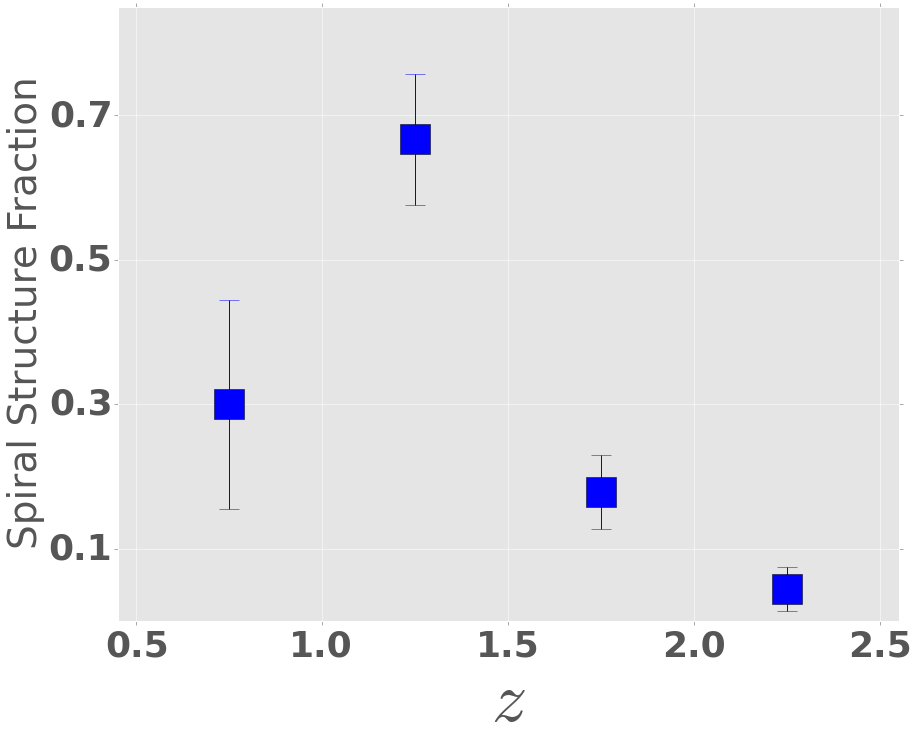

In [255]:
twoComp = pd.read_csv('../SM/2comp.csv')

#z05_spiral_cer = z05_ring_cer + z05_arm_cer + z05_ring_uncer + z05_arm_uncer
#z10_spiral_cer = z10_ring_cer + z10_arm_cer + z05_ring_uncer + z05_arm_uncer
#z15_spiral_cer = z15_ring_cer + z15_arm_cer + z05_ring_uncer + z05_arm_uncer
#z20_spiral_cer = z20_ring_cer + z20_arm_cer + z05_ring_uncer + z05_arm_uncer
z05_spiral_cer = cat_dict['z05_ring_cer'] + cat_dict['z05_arm_cer'] 
z10_spiral_cer = cat_dict['z10_ring_cer'] + cat_dict['z10_arm_cer']
z15_spiral_cer = cat_dict['z15_ring_cer'] + cat_dict['z15_arm_cer']
z20_spiral_cer = cat_dict['z20_ring_cer'] + cat_dict['z20_arm_cer']
z05_spiral_SF, z05_spiral_Que, z05_SF, z05_Que = 0.0, 0.0, 0.0, 0.0
z10_spiral_SF, z10_spiral_Que, z10_SF, z10_Que = 0.0, 0.0, 0.0, 0.0
z15_spiral_SF, z15_spiral_Que, z15_SF, z15_Que = 0.0, 0.0, 0.0, 0.0
z20_spiral_SF, z20_spiral_Que, z20_SF, z20_Que = 0.0, 0.0, 0.0, 0.0

for name in z05_spiral_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z05_spiral_SF += 1
    else:
        z05_spiral_Que += 1       
for name in z10_spiral_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z10_spiral_SF += 1
    else:
        z10_spiral_Que += 1
for name in z15_spiral_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z15_spiral_SF += 1
    else:
        z15_spiral_Que += 1
for name in z20_spiral_cer:
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z20_spiral_SF += 1
    else:
        z20_spiral_Que += 1
        

for name in np.array(z05.Name.values):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z05_SF += 1
    else:
        z05_Que += 1
for name in np.array(z10.Name.values):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z10_SF += 1
    else:
        z10_Que += 1
for name in np.array(z15.Name.values):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z15_SF += 1
    else:
        z15_Que += 1
for name in np.array(z20.Name.values):
    if int(twoComp[twoComp.Name == name]['SF1_Quies0']) == 1:
        z20_SF += 1
    else:
        z20_Que += 1

p05_SF, p05_Que, p05_both = z05_spiral_SF/z05_SF,z05_spiral_Que/z05_Que,(z05_spiral_SF+z05_spiral_Que)/(z05_Que+z05_SF)
p10_SF, p10_Que, p10_both = z10_spiral_SF/z10_SF,z10_spiral_Que/z10_Que,(z10_spiral_SF+z10_spiral_Que)/(z10_Que+z10_SF)
p15_SF, p15_Que, p15_both = z15_spiral_SF/z15_SF,z15_spiral_Que/z15_Que,(z15_spiral_SF+z15_spiral_Que)/(z15_Que+z15_SF)
p20_SF, p20_Que, p20_both = z20_spiral_SF/z20_SF,z20_spiral_Que/z20_Que,(z20_spiral_SF+z20_spiral_Que)/(z20_Que+z20_SF)

p05_SF_err,p05_Que_err,p05_both_err = binomial_err(p05_SF,z05_SF),binomial_err(p05_Que,z05_Que),binomial_err(p05_both,z05_Que+z05_SF)
p10_SF_err,p10_Que_err,p10_both_err = binomial_err(p10_SF,z10_SF),binomial_err(p10_Que,z10_Que),binomial_err(p10_both,z10_Que+z10_SF)
p15_SF_err,p15_Que_err,p15_both_err = binomial_err(p15_SF,z15_SF),binomial_err(p15_Que,z15_Que),binomial_err(p15_both,z15_Que+z15_SF)
p20_SF_err,p20_Que_err,p20_both_err = binomial_err(p20_SF,z20_SF),binomial_err(p20_Que,z20_Que),binomial_err(p20_both,z05_Que+z20_SF)

SF_fraction = [p05_SF,p10_SF,p15_SF,p20_SF]
QUI_fraction = [p05_Que,p10_Que,p15_Que,p20_Que]
both_fraction = [p05_both,p10_both,p15_both,p20_both]
SF_fraction_err = [p05_SF_err,p10_SF_err,p15_SF_err,p20_SF_err]
QUI_fraction_err = [p05_Que_err,p10_Que_err,p15_Que_err,p20_Que_err]
both_fraction_err = [p05_both_err,p10_both_err,p15_both_err,p20_both_err]


z = [0.75,1.25,1.75,2.25]
    
plt.figure(figsize=(14,11))
font = {'weight' : 'bold', 'size': 20}
matplotlib.rc('font', **font)
# Adjusting the size of xlabel and ylabel
plt.rcParams['font.size'] = 20
plt.style.use('ggplot')

plt.plot(np.array(z),SF_fraction,marker='s',color='blue', 
         linestyle='None',markersize=30, label='Star Forming')
plt.errorbar(np.array(z),SF_fraction, yerr=SF_fraction_err, color='blue', marker='.', 
                 elinewidth = 1,linestyle='None', markerfacecolor='none',capsize=10)

plt.tick_params(axis='x', labelsize=36)
plt.tick_params(axis='y', labelsize=36)
plt.xlim(0.45,2.55)
plt.ylim(0,.85)
plt.yticks([0.1,0.3,0.5,0.7])
plt.xlabel('$z$',fontsize=70)
plt.ylabel('Spiral Structure Fraction',fontsize=39)

plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Paper3/Spiral_Fraction.ps')
plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Thesis/Sample/Chapter4/Spiral_Fraction.pdf')

# Light Distribution Evolution

In [159]:
def light_distribution_median(cat):
    re0025,re0035,re0050,re0070,re0095,re012,re015,re020,re025,re030,re040,re050,\
    re060,re070,re080,re100,re120,re140,re170,re200 = \
    [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
    for name in np.array(cat['Name']):
        z = float(twoComp[twoComp['Name'] == name]['z'])
        ellipse = asciitable.read(PATH + '1D/' + name[:-4] + '_2ser_unconv.dat')
        sma1, mu1 = ellipse['col1']*phys.physical_scale(z)*0.06,-2.5*np.log10(ellipse['col2']/(0.06*0.06)) - 10*np.log10(1+z) + 26
        for i in range(len(sma1)):
            if sma1[i] < 0.25:
                re0025.append(mu1[i])
            elif sma1[i] < 0.35:
                re0035.append(mu1[i])
            elif sma1[i] < 0.50:
                re0050.append(mu1[i])
            elif sma1[i] < 0.70:
                re0070.append(mu1[i])
            elif sma1[i] < 0.95:
                re0095.append(mu1[i])
            elif sma1[i] < 1.20:
                re012.append(mu1[i])
            elif sma1[i] < 1.50:
                re015.append(mu1[i])
            elif sma1[i] < 2.00:
                re020.append(mu1[i])
            elif sma1[i] < 2.50:
                re025.append(mu1[i])
            elif sma1[i] < 3.0:
                re030.append(mu1[i])
            elif sma1[i] < 4.0:
                re040.append(mu1[i])
            elif sma1[i] < 5.0:
                re050.append(mu1[i])
            elif sma1[i] < 6.0:
                re060.append(mu1[i])
            elif sma1[i] < 7.0:
                re070.append(mu1[i])
            elif sma1[i] < 8.0:
                re080.append(mu1[i])
            elif sma1[i] < 10:
                re100.append(mu1[i])
            elif sma1[i] < 12:
                re120.append(mu1[i])
            elif sma1[i] < 14:
                re140.append(mu1[i])
            elif sma1[i] < 17:
                re170.append(mu1[i])
            elif sma1[i] < 20:
                re200.append(mu1[i])
    all = [re0025,re0035,re0050,re0070,re0095,re012,re015,re020,re025,re030,re040,re050,
           re060,re070,re080,re100,re120,re140,re170,re200]
    MUs = [np.median(x) for x in all]
    return MUs

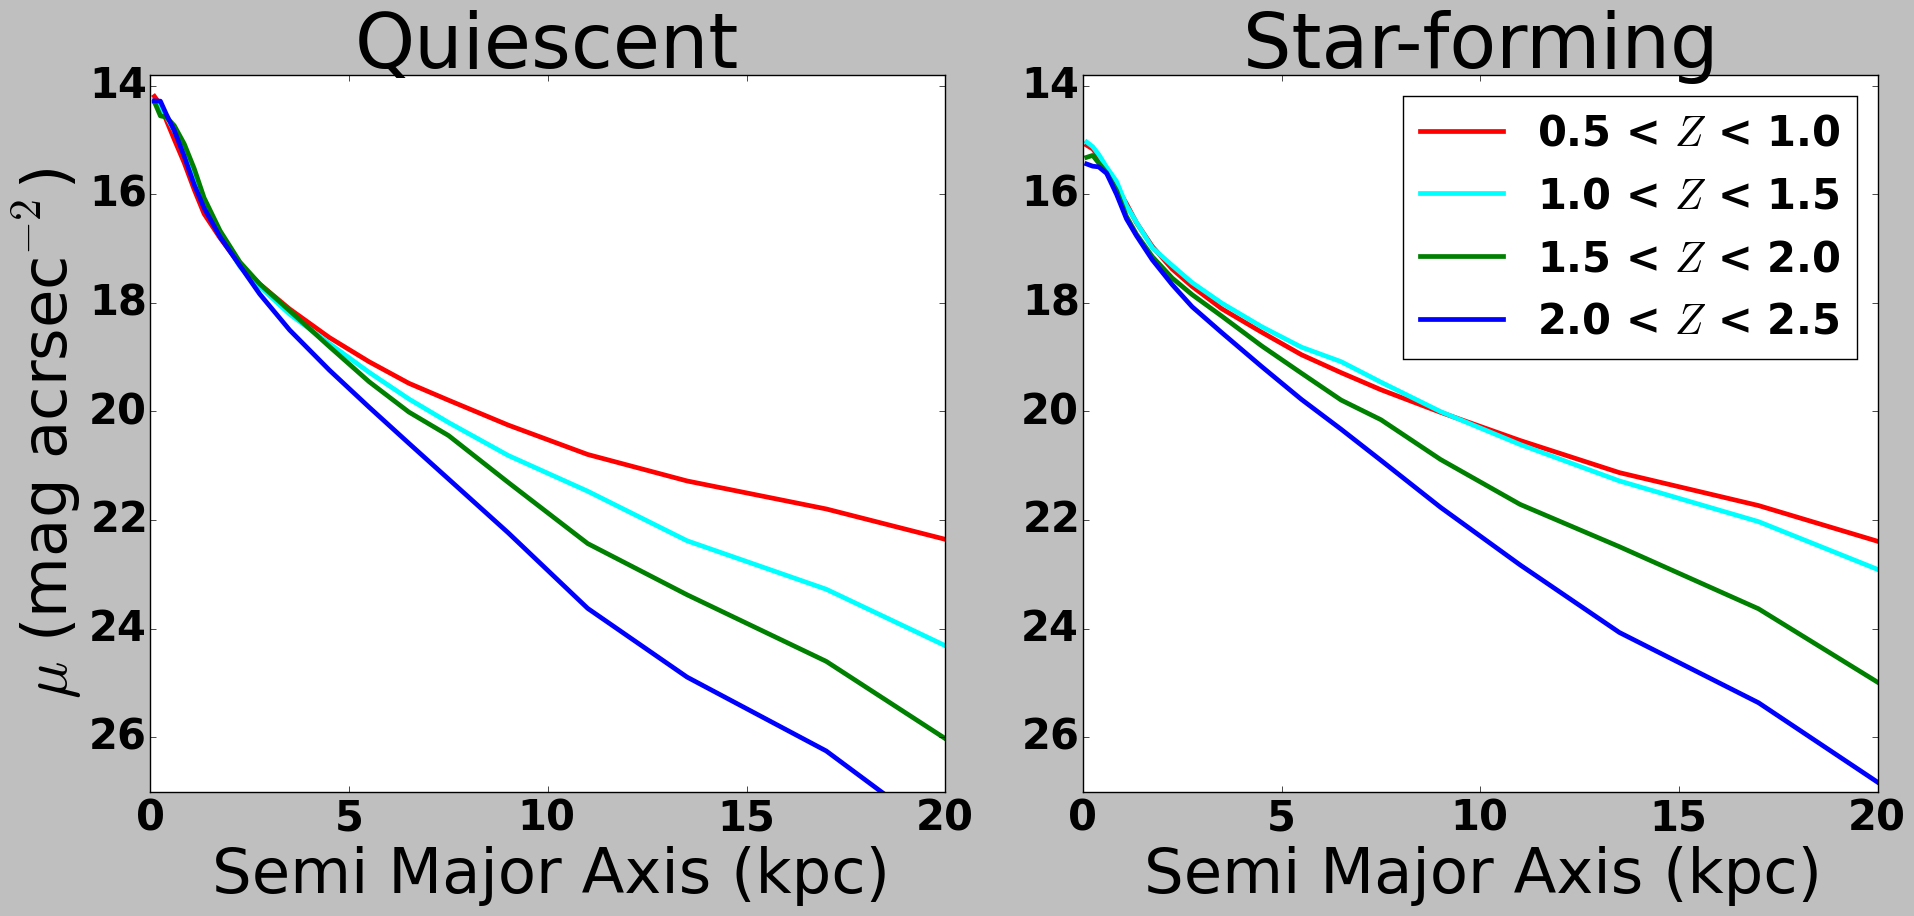

In [165]:
z05,z10,z15,z20 = four_bin(twoComp)

plt.rcdefaults()

gs = gridspec.GridSpec(1,2)
plt.figure(figsize=(20,10))
font = {'weight' : 'bold', 'size': 20}
matplotlib.rc('font', **font)
# Adjusting the size of xlabel and ylabel
plt.rcParams['font.size'] = 35
#plt.style.use('ggplot')


SMA = [0.1, 0.25, 0.4, 0.6, 0.85, 1.1, 1.35, 1.75, 2.25, 2.75, 3.5, 4.5, 5.5, 6.5, 7.5, 9, 11, 13.5, 17, 20]
#SMA = np.array(SMA)**.25

ax1 = plt.subplot(gs[:,0])
ax1.set_xlabel('Semi Major Axis (kpc)',fontsize=45)
ax1.set_ylabel('$\mu$ (mag acrsec$^{-2}$)',fontsize=45) 
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
ax1.set_xlim(0,20)
ax1.set_ylim(27,13.8)
ax1.set_title('Quiescent',fontsize=55)
ax1.plot(SMA,light_distribution_median(z05[z05['SF1_Quies0'] == 0]),color='red',linewidth=3.4,linestyle='-',label='0.5 < $Z$ < 1.0')
ax1.plot(SMA,light_distribution_median(z10[z10['SF1_Quies0'] == 0]),color='cyan',linewidth=3.4,linestyle='-',label='1.0 < $Z$ < 1.5')
ax1.plot(SMA,light_distribution_median(z15[z15['SF1_Quies0'] == 0]),color='green',linewidth=3.4,linestyle='-',label='1.5 < $Z$ < 2.0')
ax1.plot(SMA,light_distribution_median(z20[z20['SF1_Quies0'] == 0]),color='blue',linewidth=3.4,linestyle='-',label='2.0 < $Z$ < 2.5')

ax2 = plt.subplot(gs[:,1])
ax2.set_xlabel('Semi Major Axis (kpc)',fontsize=45)
ax2.set_xlim(0,20)
ax2.set_ylim(27,13.8)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
ax2.set_title('Star-forming',fontsize=55)
ax2.plot(SMA,light_distribution_median(z05[z05['SF1_Quies0'] == 1]),color='red',linewidth=3.4,linestyle='-',label='0.5 < $Z$ < 1.0')
ax2.plot(SMA,light_distribution_median(z10[z10['SF1_Quies0'] == 1]),color='cyan',linewidth=3.4,linestyle='-',label='1.0 < $Z$ < 1.5')
ax2.plot(SMA,light_distribution_median(z15[z15['SF1_Quies0'] == 1]),color='green',linewidth=3.4,linestyle='-',label='1.5 < $Z$ < 2.0')
ax2.plot(SMA,light_distribution_median(z20[z20['SF1_Quies0'] == 1]),color='blue',linewidth=3.4,linestyle='-',label='2.0 < $Z$ < 2.5')
ax2.legend(loc='best', numpoints=1, ncol=1, fontsize=30)

plt.tight_layout()

plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Paper3/light_distribution_evolution.ps')
#plt.savefig('/Users/Roozbeh/Desktop/work/Writings/Thesis/Davari/Chapter4/light_distribution_evolution.pdf')

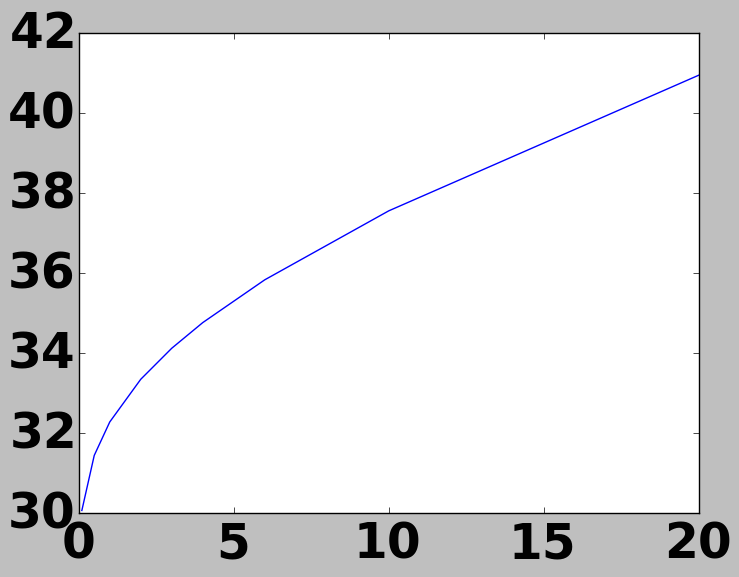

In [164]:
def bn(n):
    return 1.9992*n-0.3271

def fn(n):
    bn = 1.9992*n-0.3271
    return n * math.pow(math.e,bn) * math.gamma(2*n) / math.pow(bn,2*n)

magzpt = 26

r = np.array([0.1,0.5,1,2,3,4,6,10,20])

re = 2.0
magB = 16.0
n = 4.0
eB = 0.2
h = 5.0
magD = 16
eD = 0.4
RE = 10.0

sbB = magB + 2.5*math.log10(2*math.pi*math.pow(re*0.396*math.sqrt(1-eB),2)*fn(n))
sbD = magD + 2.5*math.log10(2*math.pi*math.pow(1.678*h*0.396*math.sqrt(1-eD),2)*fn(1)) - 1.822

muB = sbB + (2.5*bn(n)/np.log(10)) * ((r/RE)**(1/n) - 1)
muD = sbD + (2.5*bn(1)/np.log(10)) * (r/RE - 1)

#plt.ylim(19,12)
plt.plot(r,muB+muD)

In [413]:
def findInitial_e_PA(imageName, Type):
    """
    finds the measured ellipticity and position angle for the galaxy.
    It is using the fact that the galaxy in at the center of the imgae
    """
    e0 = make_float(twoComp[twoComp.Name == imageName]['e_d'])
    PA0 = make_float(twoComp[twoComp.Name == imageName]['PA_d'])
    
    return (e0, PA0)

In [414]:
def ellipse(imageName, e0, PA0, Type, Directory='2comp',\
            hold_e='yes', hold_PA='yes', magzpt=26, step_size=0.04):
    """
    Baically does what ELLIPSE/IRAF does but have limited options for editing
    """
     
    # Creating the parameter file for ELLIPSE
    fp = open(PATH + '/Par/ellipse.par','r')
    ellipse_par = fp.readlines()
    fp.close()  

    if Type.lower() == 'galaxy': 
        image_size = len(pyfits.open(PATH + 'Fits/' + Directory +'/' + imageName[:-3] + '2ser_galaxy.fit')[0].data)    
        ellipse_par[0] = 'ellipse.input = ' + PATH  + 'Fits/2comp/' + imageName[:-3] + '2ser_galaxy.fit' + '\n'
    elif Type.lower() == 'model': 
        image_size = len(pyfits.open(PATH + 'Fits/' + Directory +'/' + imageName[:-3] + '2ser_model.fit')[0].data)    
        ellipse_par[0] = 'ellipse.input = ' + PATH  + 'Fits/2comp//' + imageName[:-3] + '2ser_model.fit' + '\n'
    elif Type.lower() == 'bulge':
        image_size = len(pyfits.open(PATH + 'Fits/' + Directory +'/' + imageName[:-3] + '2ser_bulge.fit')[0].data)    
        ellipse_par[0] = 'ellipse.input = ' + PATH  + 'Fits/2comp/' + imageName[:-3] + '2ser_bulge.fit' + '\n'
    elif Type.lower() == 'disk':
        image_size = len(pyfits.open(PATH + 'Fits/' + Directory +'/' + imageName[:-3] + '2ser_disk.fit')[0].data)    
        ellipse_par[0] = 'ellipse.input = ' + PATH  + 'Fits/2comp/' + imageName[:-3] + '2ser_disk.fit' + '\n'
    elif Type.lower() == 'unconv':
        image_size = len(pyfits.open(PATH + 'Fits/2comp/' + imageName[:-3] + '2ser_unconv.fit')[0].data)    
        ellipse_par[0] = 'ellipse.input = ' + PATH  + 'Fits/2comp/' + imageName[:-3] + '2ser_unconv.fit' + '\n'
        
    ellipse_par[1] = 'ellipse.output = ' + PATH + '1D/' + imageName[:-3] + '2ser' + '_' + Type + '.bin' + '\n'
    ellipse_par[2] = 'geompar.x0= ' + str(image_size/2) + '\n'
    ellipse_par[3] = 'geompar.y0= ' + str(image_size/2) + '\n'
    ellipse_par[4] = 'geompar.ellip0 = ' + str(e0) + '\n'
    ellipse_par[5] = 'geompar.pa0 = ' + str(PA0) + '\n'
    ellipse_par[6] = 'magpar.mag0 = ' + str(magzpt) + '\n'
    ellipse_par[7] = 'geompar.maxsma = ' + str(image_size/2) + '\n'
    ellipse_par[8] = 'controlpar.hellip = ' + str(hold_e) + '        \n'
    ellipse_par[9] = 'controlpar.hpa = ' + str(hold_PA) + '           \n'
    ellipse_par[10] = 'geompar.step = ' + str(step_size) + '          \n' 
   
    output = open(PATH + '/Par/ellipse' + imageName + '.par','w')
    output.writelines(ellipse_par)
    output.close()  
    
    # Running ELLIPSE
    os.system('/usr/stsci/stsci_iraf-3.14/stsdas/bin.macintel/x_isophote.e \
               ellipse @' + PATH + '/Par/ellipse' + imageName + '.par')

    # Removing the parameter file
    os.system('rm ' + PATH + '/Par/ellipse' + imageName + '.par')

In [415]:
def tdump(imageName, Type):
    """
    Baically does what Tdump/IRAF does
    """  
    
    # Creating the parameter file for Tdump
    ff = open(PATH + '/Par/tdump.par','r')
    tdump_param = ff.readlines()
    ff.close()
    
    tdump_param[0] = 'tdump.table = ' +  PATH + '1D/' + imageName[:-3] + '2ser' + '_' + Type + '.bin' + '\n'
    tdump_param[3] = 'tdump.datafile = ' +  PATH + '1D/' + imageName[:-3] + '2ser' + '_' + Type + '.dat' + '\n'
    
    output = open(PATH + '/Par/tdump' + imageName + '.par','w')
    output.writelines(tdump_param)
    output.close()
    
    # Running Tdump and removing the parameter file
    os.system('/usr/stsci/stsci_iraf-3.14/tables/bin.macintel/x_ttools.e \
                tdump @' + PATH + '/Par/tdump' + imageName + '.par')  
    os.system('rm ' + PATH + '/Par/tdump' + imageName + '.par') 
    
def round3(x): return round(x,3)

def make_float(parameter):
    try:
        return float(parameter[0])
    except:
        return float(parameter)

# Very Thin Disk

In [75]:
thinOne = singleSer[singleSer['e'] >= 0.6]
z05,z10,z15,z20 = four_bin(thinOne,lim1=1,lim2=1.5,lim3=2)
z05_all,z10_all,z15_all,z20_all = four_bin(singleSer,lim1=1,lim2=1.5,lim3=2)

z05_Que, z05_SF = float(sum(z05_all.SF1_Quies0 == 0)), float(sum(z05_all.SF1_Quies0 == 1))
p05_Que = sum(z05.SF1_Quies0 == 0)/z05_Que
p05_SF = sum(z05.SF1_Quies0 == 1)/z05_SF
p05_both = len(z05)/float(len(z05_all))

z10_Que, z10_SF = float(sum(z10_all.SF1_Quies0 == 0)), float(sum(z10_all.SF1_Quies0 == 1))
p10_Que = sum(z10.SF1_Quies0 == 0)/z10_Que
p10_SF = sum(z10.SF1_Quies0 == 1)/z10_SF
p10_both = len(z10)/float(len(z10_all))

z15_Que, z15_SF = float(sum(z15_all.SF1_Quies0 == 0)), float(sum(z15_all.SF1_Quies0 == 1))
p15_Que = sum(z15.SF1_Quies0 == 0)/z15_Que
p15_SF = sum(z15.SF1_Quies0 == 1)/z15_SF
p15_both = len(z15)/float(len(z15_all))

z20_Que, z20_SF = float(sum(z20_all.SF1_Quies0 == 0)), float(sum(z20_all.SF1_Quies0 == 1))
p20_Que = sum(z20.SF1_Quies0 == 0)/z20_Que
p20_SF = sum(z20.SF1_Quies0 == 1)/z20_SF
p20_both = len(z20)/float(len(z20_all))


p05_SF_err,p05_Que_err,p05_both_err = binomial_err(p05_SF,z05_SF),binomial_err(p05_Que,z05_Que),binomial_err(p05_both,z05_Que+z05_SF)
p10_SF_err,p10_Que_err,p10_both_err = binomial_err(p10_SF,z10_SF),binomial_err(p10_Que,z10_Que),binomial_err(p10_both,z10_Que+z10_SF)
p15_SF_err,p15_Que_err,p15_both_err = binomial_err(p15_SF,z15_SF),binomial_err(p15_Que,z15_Que),binomial_err(p15_both,z15_Que+z15_SF)
p20_SF_err,p20_Que_err,p20_both_err = binomial_err(p20_SF,z20_SF),binomial_err(p20_Que,z20_Que),binomial_err(p20_both,z05_Que+z20_SF)

print p05_Que,p05_Que_err,p05_SF,p05_SF_err,p05_both,p05_both_err
print p10_Que,p10_Que_err,p10_SF,p10_SF_err,p10_both,p10_both_err
print p15_Que,p15_Que_err,p15_SF,p15_SF_err,p15_both,p15_both_err
print p20_Que,p20_Que_err,p20_SF,p20_SF_err,p20_both,p20_both_err

0.0 0.0 0.1 0.0948683298051 0.0322580645161 0.0317335081831
0.0869565217391 0.0587533847558 0.185185185185 0.0747567988666 0.14 0.0490713765855
0.121212121212 0.0568143555492 0.125 0.0441941738242 0.123595505618 0.0348865990512
0.125 0.0584633966683 0.0909090909091 0.0433392086021 0.105263157895 0.0380652931937


In [463]:
thinDisk = np.array(singleSer[singleSer['e'] > 0.6]['Name'])
thinDisk = sorted(thinDisk)

ds9_command = 'ds9 '
for each in thinDisk:
    ds9_command += PATH + '/Fits/Sample/FINE/' + each + '.fit '
os.system(ds9_command + '&')

In [465]:
ds9_command

'ds9 /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z0.8_m11.0_27293.0_cosmos_drz.fit /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.0_m11.0_5483_gn_drz.fit /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.0_m11.0_927.0_egs_drz.fit /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.1_m11.0_24796.0_gs_drz.fit /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.1_m11.1_13866.0_egs_drz.fit /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.3_m11.0_19814.0_gs_drz.fit /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.4_m11.0_27849.0_egs_drz.fit /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.4_m11.0_3366_gn_drz.fit /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.5_m10.9_20490_uds_drz.fit /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.6_m10.9_13729_uds_drz.fit /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.6_m10.9_22313_gn_drz.fit /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FIN

In [466]:
final = 'ds9 /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z0.8_m11.0_27293.0_cosmos_drz.fit /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.1_m11.0_24796.0_gs_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.1_m11.1_13866.0_egs_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.3_m11.0_19814.0_gs_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.4_m11.0_27849.0_egs_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.4_m11.0_3366_gn_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.5_m10.9_20490_uds_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.6_m10.9_13729_uds_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.6_m11.0_18607.0_gs_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.6_m11.0_3909.0_egs_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.8_m10.9_1237.0_egs_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z2.0_m10.8_10663_uds_drz.fit '

In [467]:
final

'ds9 /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z0.8_m11.0_27293.0_cosmos_drz.fit /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.1_m11.0_24796.0_gs_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.1_m11.1_13866.0_egs_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.3_m11.0_19814.0_gs_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.4_m11.0_27849.0_egs_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.4_m11.0_3366_gn_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.5_m10.9_20490_uds_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.6_m10.9_13729_uds_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.6_m11.0_18607.0_gs_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.6_m11.0_3909.0_egs_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2//Fits/Sample/FINE/z1.8_m10.9_1237.0_egs_drz.fit  /Users/Roozbeh/Desktop/Work/Paper3/V2/

# Disk Fraction Based on B/T<0.5

In [74]:
def binomial_err(p,n):
    return np.sqrt((p*(1-p))/n)

twoComp = pd.read_csv('../SM/2comp.csv')
twoComp = twoComp[twoComp.fitGoodness == 'high']
z05,z10,z15,z20 = four_bin(twoComp)

z05_Que, z05_SF = float(sum(z05.SF1_Quies0 == 0)), float(sum(z05.SF1_Quies0 == 1))
p05_Que = sum(z05[z05.SF1_Quies0 == 0]['BT'] <= 0.5)/z05_Que
p05_SF = sum(z05[z05.SF1_Quies0 == 1]['BT'] <= 0.5)/z05_SF
p05_both = sum(z05['BT'] <= 0.5)/float(len(z05))

z10_Que, z10_SF = float(sum(z10.SF1_Quies0 == 0)), float(sum(z10.SF1_Quies0 == 1))
p10_Que = sum(z10[z10.SF1_Quies0 == 0]['BT'] <= 0.5)/float(sum(z10.SF1_Quies0 == 0))
p10_SF = sum(z10[z10.SF1_Quies0 == 1]['BT'] <= 0.5)/float(sum(z10.SF1_Quies0 == 1))
p10_both = sum(z10['BT'] <= 0.5)/float(len(z10))

z15_Que, z15_SF = float(sum(z15.SF1_Quies0 == 0)), float(sum(z15.SF1_Quies0 == 1))
p15_Que = sum(z15[z15.SF1_Quies0 == 0]['BT'] <= 0.5)/float(sum(z15.SF1_Quies0 == 0))
p15_SF = sum(z15[z15.SF1_Quies0 == 1]['BT'] <= 0.5)/float(sum(z15.SF1_Quies0 == 1))
p15_both = sum(z15['BT'] <= 0.5)/float(len(z15))
print
z20_Que, z20_SF = float(sum(z20.SF1_Quies0 == 0)), float(sum(z20.SF1_Quies0 == 1))
p20_Que = sum(z20[z20.SF1_Quies0 == 0]['BT'] <= 0.5)/float(sum(z20.SF1_Quies0 == 0))
p20_SF = sum(z20[z20.SF1_Quies0 == 1]['BT'] <= 0.5)/float(sum(z20.SF1_Quies0 == 1))
p20_both = sum(z20['BT'] <= 0.5)/float(len(z20))


p05_SF_err,p05_Que_err,p05_both_err = binomial_err(p05_SF,z05_SF),binomial_err(p05_Que,z05_Que),binomial_err(p05_both,z05_Que+z05_SF)
p10_SF_err,p10_Que_err,p10_both_err = binomial_err(p10_SF,z10_SF),binomial_err(p10_Que,z10_Que),binomial_err(p10_both,z10_Que+z10_SF)
p15_SF_err,p15_Que_err,p15_both_err = binomial_err(p15_SF,z15_SF),binomial_err(p15_Que,z15_Que),binomial_err(p15_both,z15_Que+z15_SF)
p20_SF_err,p20_Que_err,p20_both_err = binomial_err(p20_SF,z20_SF),binomial_err(p20_Que,z20_Que),binomial_err(p20_both,z05_Que+z20_SF)

print p05_Que,p05_Que_err,p05_SF,p05_SF_err,p05_both,p05_both_err
print p10_Que,p10_Que_err,p10_SF,p10_SF_err,p10_both,p10_both_err
print p15_Que,p15_Que_err,p15_SF,p15_SF_err,p15_both,p15_both_err
print p20_Que,p20_Que_err,p20_SF,p20_SF_err,p20_both,p20_both_err


0.172413793103 0.0701445003746 0.666666666667 0.111111111111 0.36170212766 0.0700871339919
0.5 0.117851130198 0.862068965517 0.0640328752335 0.723404255319 0.0652475708695
0.642857142857 0.0905522415781 0.911111111111 0.0424231735208 0.808219178082 0.0460792851956
0.533333333333 0.0910840068085 0.931818181818 0.0379991201606 0.77027027027 0.0492344100919
